In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn
import math
import matplotlib.backends.backend_pdf
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [33]:
data_p2_read = pd.read_csv('E:\data\TRAIN_2\ph_4.csv')
data_p2_test = pd.read_csv('E:\data\ph_4_test.csv')
data_p2_test = data_p2_test[data_p2_read.columns.values]
data_p2_test[:5]

ACID  Flight_instance_ID  Year  Month  Day  Hour  Minute  Second  \
0   676     676200104290501  2001      4   29     5      10      18   
1   676     676200104290501  2001      4   29     5      10      19   
2   676     676200104290501  2001      4   29     5      10      20   
3   676     676200104290501  2001      4   29     5      10      21   
4   676     676200104290501  2001      4   29     5      10      22   

         ABRK    ELEV_1  ...       BPGR_2     BPYR_1  BPYR_2  CALT   CASS  \
0  119.983559 -3.234383  ...    39.062599  63.476723     0.0     0  131.0   
1  119.983559 -3.929955  ...    39.062599  58.593899     0.0     0  131.0   
2  119.983559 -3.643543  ...    39.062599  63.476723     0.0     0  131.0   
3  119.983559 -3.254841  ...    39.062599  58.593899     0.0     0  131.0   
4  119.983559 -2.559269  ...    39.062599  58.593899     0.0     0  131.0   

        CRSS  DFGS   DWPT  EAI     FF  
0 -139.04199     1  60440    0  11580  
1 -139.04199     1  60440    0  11566  
2 -139.04199     1  60436    0  11548  
3 -139.04199     1  60436    0  11526  
4 -139.04199     1  60436    0  11488  

[5 rows x 226 columns]

In [34]:
data_p2_columns = data_p2_read.iloc[:,9:]

time_data = data_p2_read.iloc[:,:8]
FF = data_p2_read[['FF']]
# Frames is the 2 DF's that will be concatenated
frames = [time_data.T, data_p2_columns.T]


data_p2_columns_test = data_p2_test.iloc[:,9:]

time_data_test = data_p2_test.iloc[:,:8]
FF_test = data_p2_test[['FF']]
# Frames is the 2 DF's that will be concatenated
frames_test = [time_data_test.T, data_p2_columns_test.T]


In [35]:
data_p2_columns_test.shape

(193541, 217)

In [36]:
data_p2_sample = pd.concat(frames).T
data_p2_sample_test = pd.concat(frames_test).T
flight_features=data_p2_columns.columns.values

In [37]:
data_p2_sample.shape

(251700, 225)

In [38]:
#Changing Time Notation to read into delay in seconds required

In [39]:
# Create new column for min and sec as a decimal. For example 1 min 20 sec would be 1.3
import copy
data_p3_sample = copy.deepcopy(data_p2_sample)
data_p3_sample['total_sec'] = data_p3_sample['Hour'].map(int) * 3600+ data_p3_sample['Minute'].map(int) *60 + data_p3_sample['Second'].map(int)
print data_p2_sample.shape
print data_p3_sample.shape

data_p3_sample_test = copy.deepcopy(data_p2_sample_test)
data_p3_sample_test['total_sec'] = data_p3_sample_test['Hour'].map(int) * 3600+ data_p3_sample_test['Minute'].map(int) *60 + data_p3_sample_test['Second'].map(int)
print data_p2_sample_test.shape
print data_p3_sample_test.shape

(251700, 225)
(251700, 226)
(193541, 225)
(193541, 226)


In [40]:
exclude_var=['ACID','Flight_instance_ID','Year','Month','Day','Hour','Minute','Second','total_sec']
for i in exclude_var:
    del data_p3_sample_test[i]
    del data_p3_sample[i]

In [41]:
# Remove features with 0 variance
def remove_low_variance(threshold, df):
    features_no_variance = []
    for column in range(len(df.columns)):
        if np.var(df.iloc[:,column]) == threshold:
            features_no_variance.append(df.columns[column])
    return features_no_variance

features_no_variance = remove_low_variance(0 , data_p3_sample)

In [42]:
# Remove columns
def remove_control():
    fire_columns = ['FIRE_1','FIRE_2','FIRE_3','FIRE_4']
    
    columns_to_drop = fire_columns
 
    extra_columns_drop = ['APUF_Mean','MSQT_1_Mean','MSQT_2_Mean','TOCW_Mean', 'FGC3']
    for column in extra_columns_drop:
        columns_to_drop.append(column)
        
    noisy_features = ['LMOD','SPL_2']
    for column in noisy_features:
        columns_to_drop.append(column)
    # Add columns that have no variance
    for column in features_no_variance:
        if column not in columns_to_drop:
            columns_to_drop.append(column)
        
    return columns_to_drop
  

In [43]:
 # Get correlations among features


class rf_eval():
    def __init__(self):
        self.importances = None
        self.corr_table = None
        self.corr_list = None
        
    def rf_importances(self, df):
        """Get importances for RF"""
        rf = RandomForestRegressor()

        df_train = df.sample(frac=0.1, random_state=42).drop(remove_control(), axis=1)
        
        X_train = df_train.drop(['FF'],axis=1)
        y_train = df_train['FF']

        rf.fit(X_train, y_train)
        importances = []
        coef = rf.feature_importances_
        feature = X_train.columns
        for weight in range(len(rf.feature_importances_)):
            importances.append((feature[weight], coef[weight]))
 
        self.importances = importances
        self.df_train = df_train

    def rf_corr(self):
        """Get correlation table"""
        features_important = []
        for tup in self.importances:
            if tup[1] >= 0:
                features_important.append(tup[0])
                
        df_clean = self.df_train
        corr_table = df_clean[features_important].corr()
        self.corr_table = corr_table
        
    def get_correlations(self):
        """Get a list of tuples for each"""
        corr_list = []
        features = self.corr_table.columns
        
        counter = 0
        while counter < len(features):

            for iteration in range(counter, len(features)):
                corr_coef = self.corr_table.ix[counter, iteration]
                f1 = self.corr_table.columns[counter]
                f2 = self.corr_table.columns[iteration]
                
                if corr_coef != 1:
                    corr_list.append((f1,f2,self.corr_table.ix[counter, iteration]))
            counter += 1
        self.corr_list = corr_list
            
            
        
rf_eval = rf_eval()

rf_eval.rf_importances(data_p3_sample)
rf_eval.rf_corr()
rf_eval.get_correlations()


In [44]:
corr_coef_list = sorted(rf_eval.corr_list, key=lambda x: np.abs(x[2]), reverse=True)

In [45]:
corr_coef_list

[]

In [31]:
data_p3_sample[:5]

ELEV_1   ELEV_2 EVNT FADF FADS FGC3 FIRE_1 FIRE_2 FIRE_3 FIRE_4  ...    \
0 -3.99133  82.4682    1   15   15  120      0      0      0      0  ...     
1 -3.62309  82.2841    1   15   15  120      0      0      0      0  ...     
2 -4.13453  82.1613    1   15   15  120      0      0      0      0  ...     
3 -3.80721  82.3659    1   15   15  120      0      0      0      0  ...     
4  -3.4185  80.7702    1   15   15  120      0      0      0      0  ...     

    BPGR_2   BPYR_1 BPYR_2 CALT CASS     CRSS DFGS   DWPT EAI     FF  
0  34.1798  58.5939      0    0  137 -22.0604    1  42140   0  10536  
1  34.1798  58.5939      0    0  137 -22.0604    1  42140   0  10522  
2  34.1798  58.5939      0    0  137 -22.0604    1  42140   0  10508  
3  34.1798  58.5939      0    0  137 -22.0604    1  42144   0  10498  
4  34.1798  58.5939      0    0  137 -22.0604    1  42144   0  10484  

[5 rows x 217 columns]

In [11]:
import time
from sklearn.ensemble import RandomForestRegressor
class rfError:
    def __init__(self):
        self.rmse = None
        self.ymean = None
        self.mape = None
    def cv_rf(self, 
              df_train, 
              df_test, 
              sample = None):
        
        if sample == None:
            sample = 0.2
        else:
            sample = sample
        rf = RandomForestRegressor()
        
        rmse_store = []
        y_mean_store = []
        df_train = df_train.sample(frac=sample, random_state=42)
        
        X_train = df_train.ix[:,8:].drop(['FF'],axis=1)
        y_train = df_train['FF']
        X_test =  df_test.ix[:,8:].drop(['FF'], axis=1)
        y_test = df_test['FF']
            
        rf.fit(X_train,y_train)
        rmse = np.mean((rf.predict(X_test) - y_test)**2)**0.5
        rmse_store.append(rmse)
        y_mean_store.append(np.mean(y_test))
            
        self.rmse = np.mean(rmse_store)
        self.ymean = np.mean(y_mean_store)
        self.mape = np.mean(1.0 * self.rmse / self.ymean)
t0 = time.time()
# Initialize function
rfe = rfError()
# Fit and predict model
rfe.cv_rf(data_p3_sample, data_p3_sample_test)
print rfe.rmse
print rfe.mape

216.684445438
0.0294947673503


In [45]:
# Make Flight Instance ID a string
data_p3_sample['Flight_instance_ID'] = data_p3_sample['Flight_instance_ID'].map(lambda x: str("{}".format(x)))

# List of flight indexes for each flight instance
test_indexes = list(enumerate(data_p3_sample['Flight_instance_ID'].unique()))

# Create function to search for flight index if you only know the flight instance
def get_flight_instance_index(instance_num):
    index_match = [index for index, instance in test_indexes if instance_num == instance]
    return "".join(str(index_match[0]))
# Create function to plot 
def make_dual_plot(feature, flight_index):  
    test_instance = data_p3_sample['Flight_instance_ID'].unique()[flight_index]
    test_flight_data = data_p3_sample[data_p3_sample['Flight_instance_ID'] == test_instance]
    # Fuel Flow
    fig2, ax1 = plt.subplots()
    x = test_flight_data['total_sec']
    y1_ff = test_flight_data['FF']
    ax1.plot(x,y1_ff, color='r')
    ax1.set_ylabel('FF')
    plt.legend(loc=1)
    # Second variable
    y2_variable = feature
    y2 = test_flight_data[y2_variable].astype(float)
    ax2 = ax1.twinx()
    ax2.plot(x,y2)
    ax2.set_ylabel(y2_variable)
    plt.legend(loc=4)
    
    plt.title("FF and {} as a function of time - Flight {}".format(y2_variable, test_instance))
#pdf.savefig( fig2 )
#     print "Test Instance:", "ID:",get_flight_instance_index(test_instance),"Instance:",test_instance
    
# print test_indexes[9]

var_gt1=[]
var_eq1=[]
for i in data_p3_sample.columns.values:
    if (data_p3_sample[i].unique().shape[0])>1:
        var_gt1.append(i)
    else: 
        var_eq1.append(i)      


In [53]:
##need to run multiple times##
flight_features = list(flight_features)
for i in flight_features:
    if i in var_eq1:
        flight_features.remove(i)

In [54]:
len(flight_features)

180

In [55]:
list_of_vars_close_to_zero=['FGC3','FQTY2','ILSF','TAI','VHF2','WAI_1','MSQT_1_Min','MSQT_1_Max','MSQT_1_Mean','MSQT_2_Mean',
                           'MSQT_2_Min','MSQT_2_Max','A_T','CRSS','EAI']

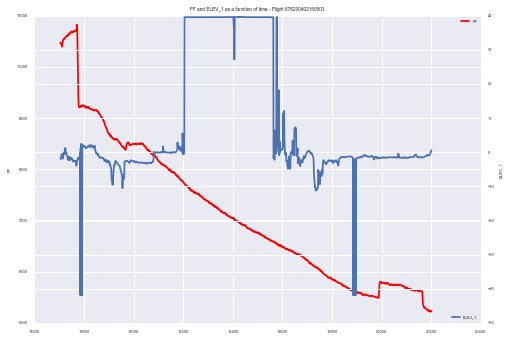

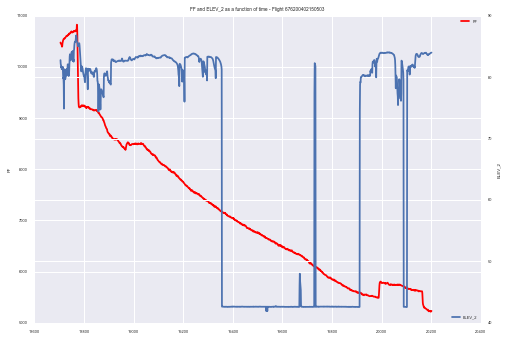

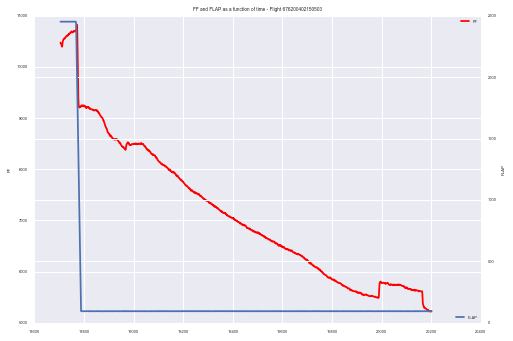

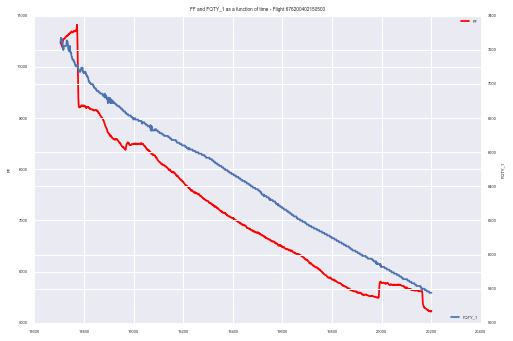

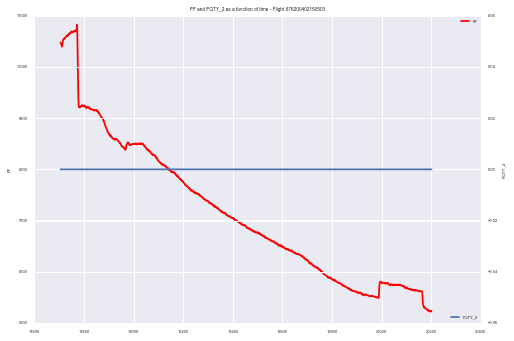

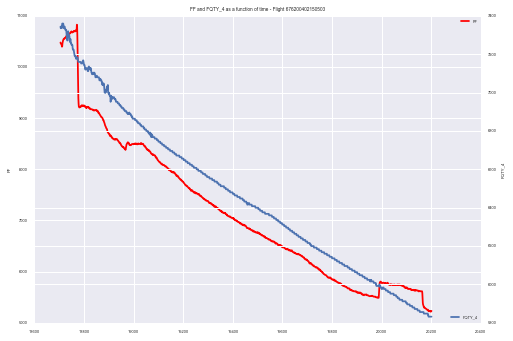

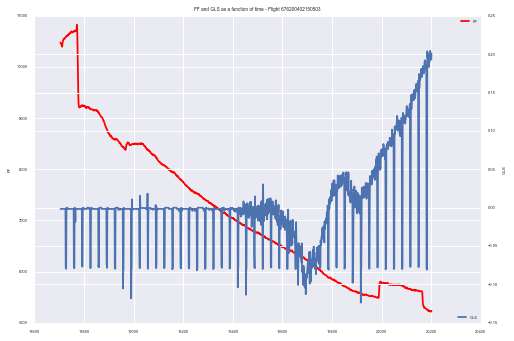

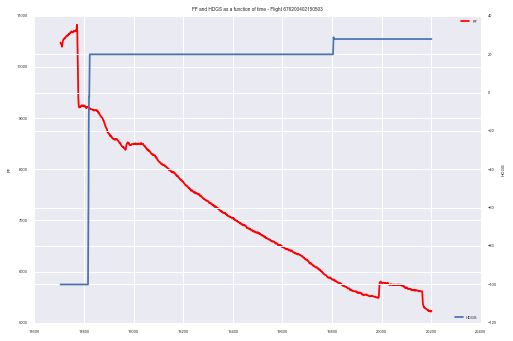

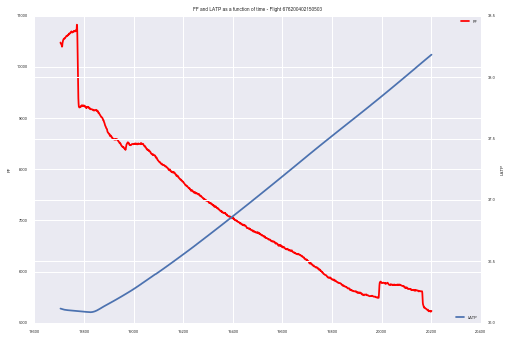

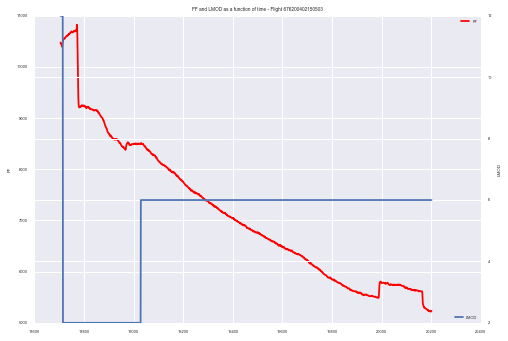

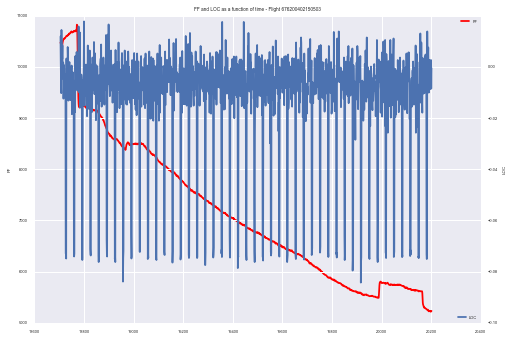

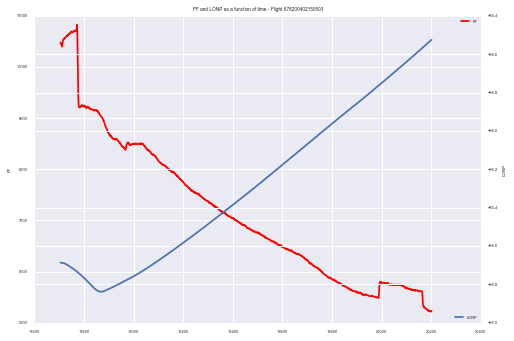

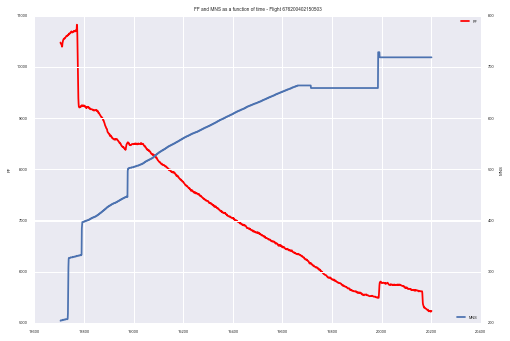

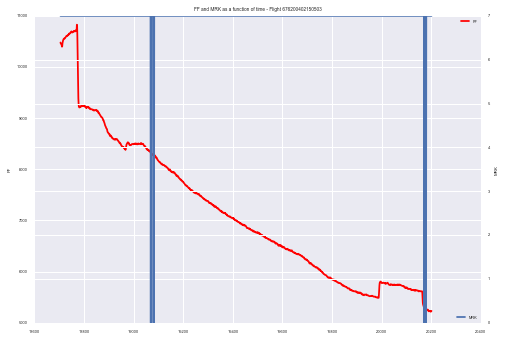

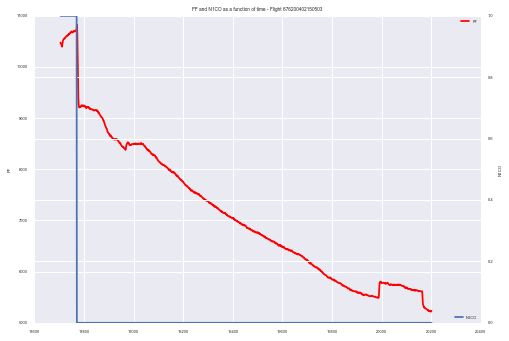

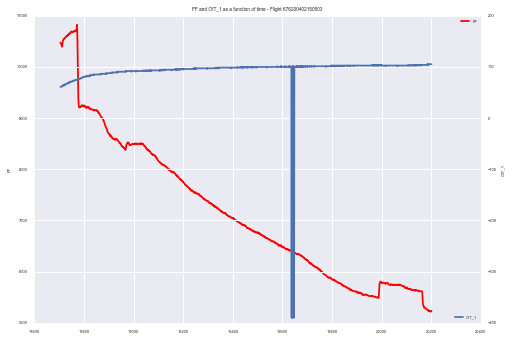

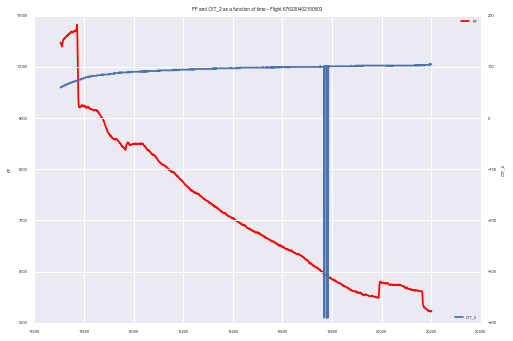

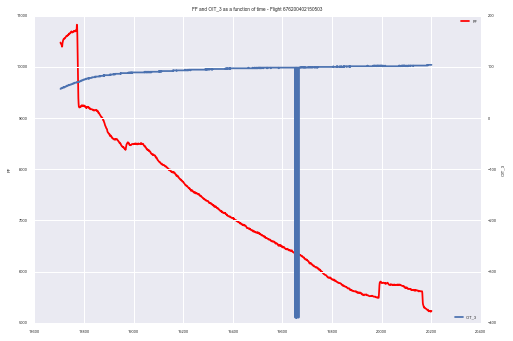

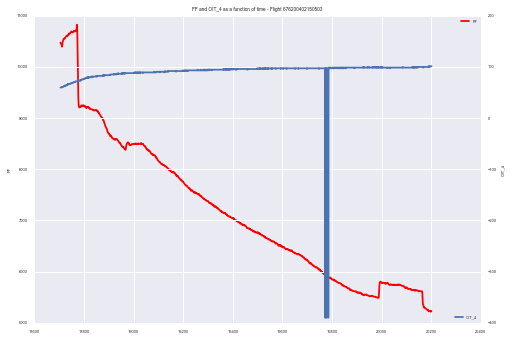

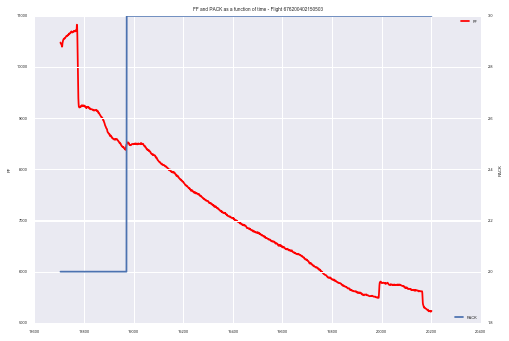

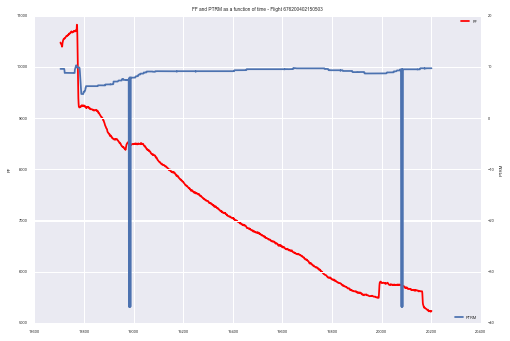

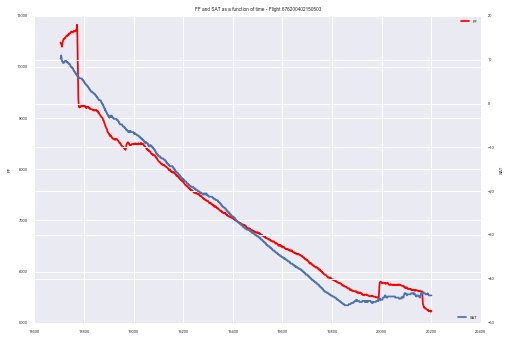

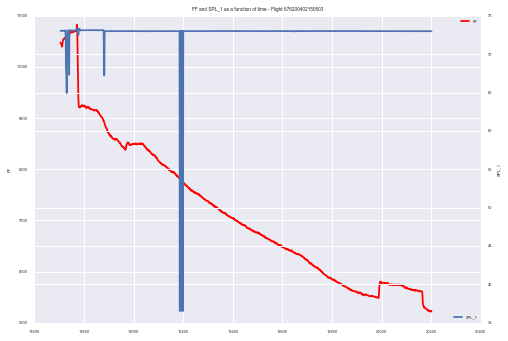

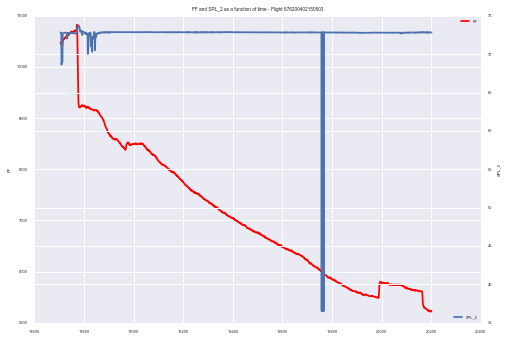

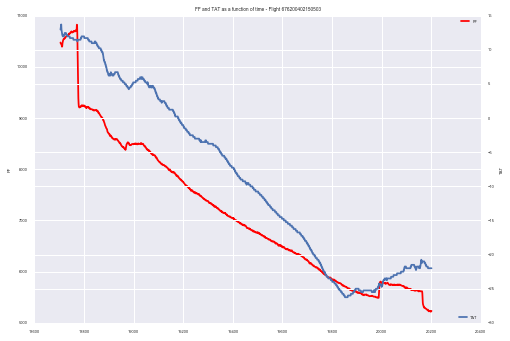

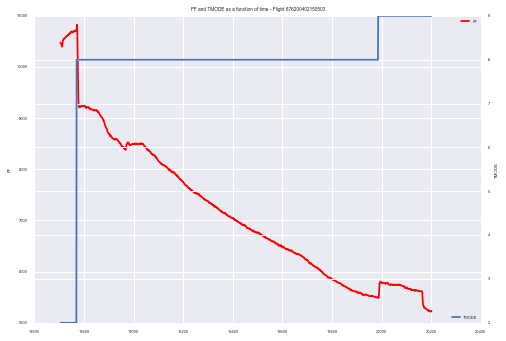

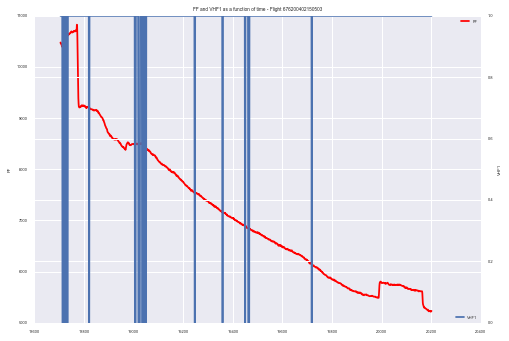

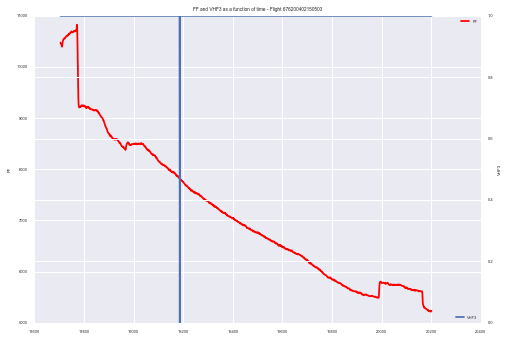

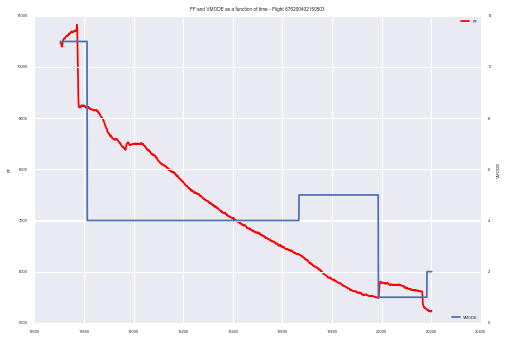

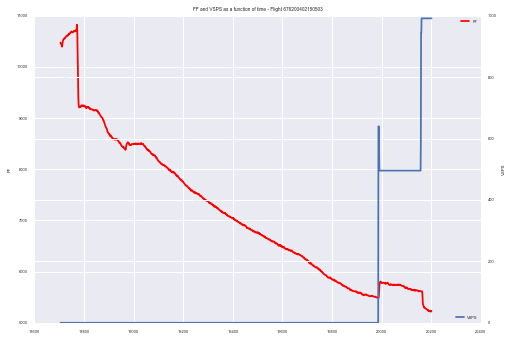

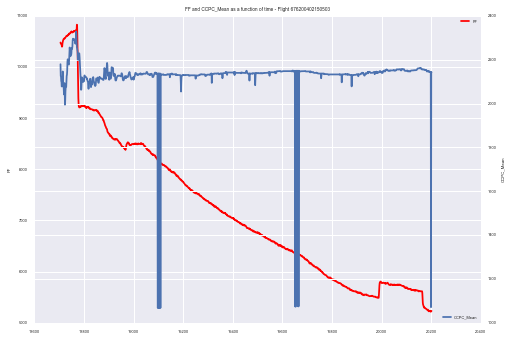

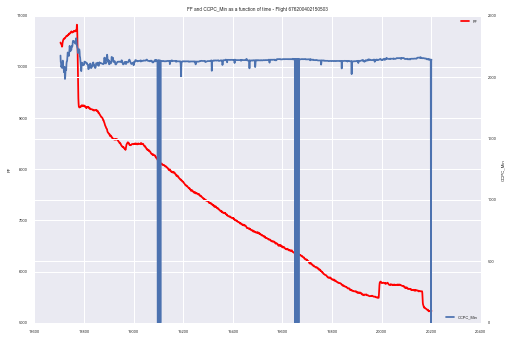

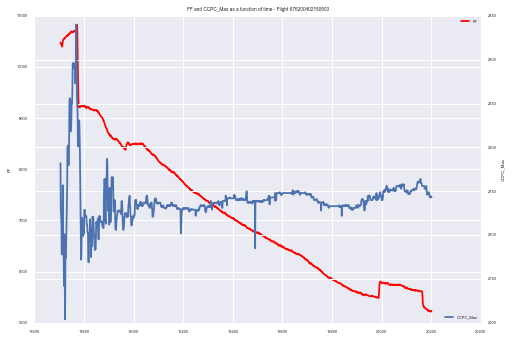

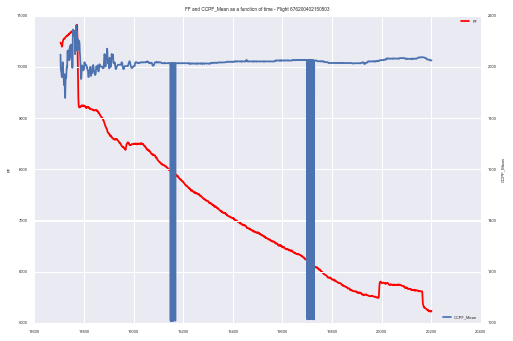

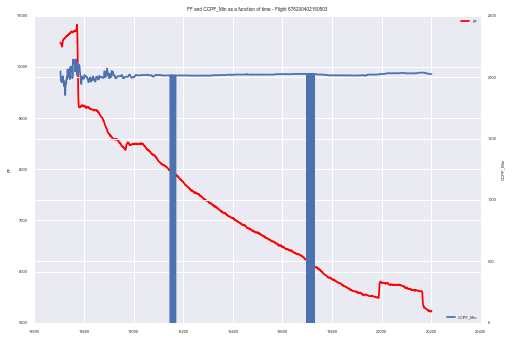

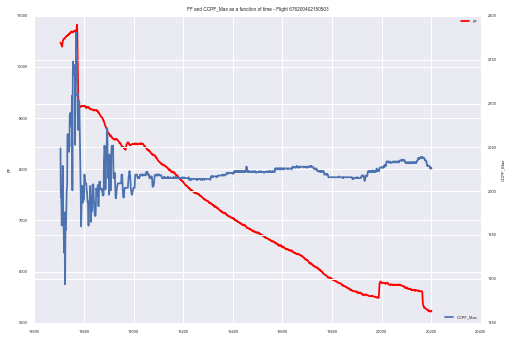

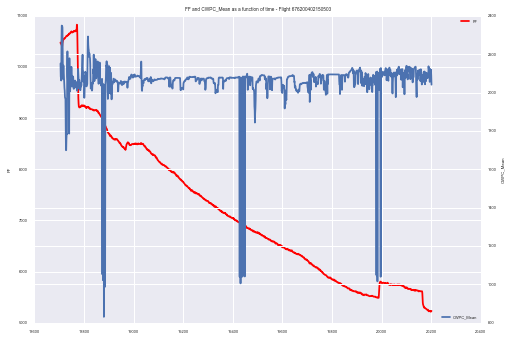

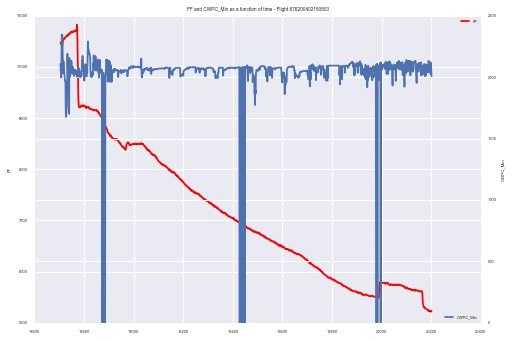

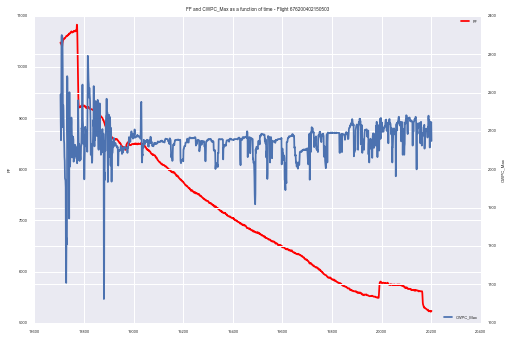

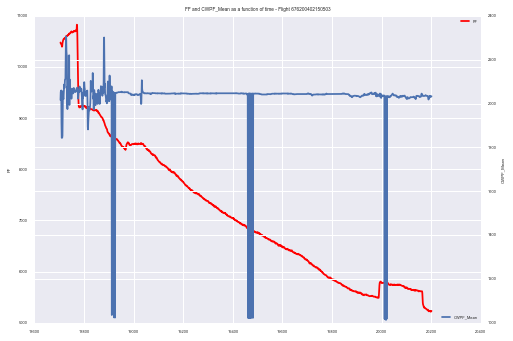

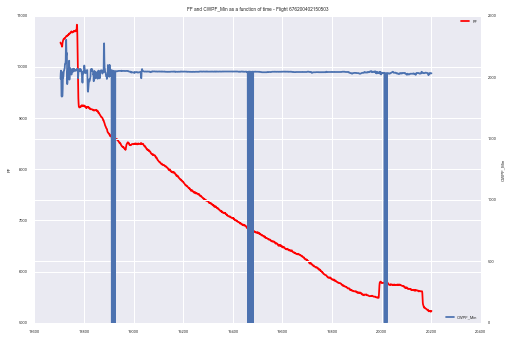

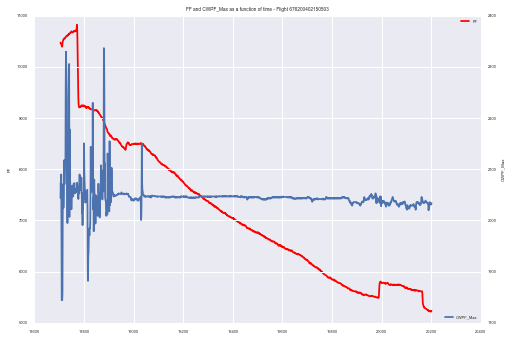

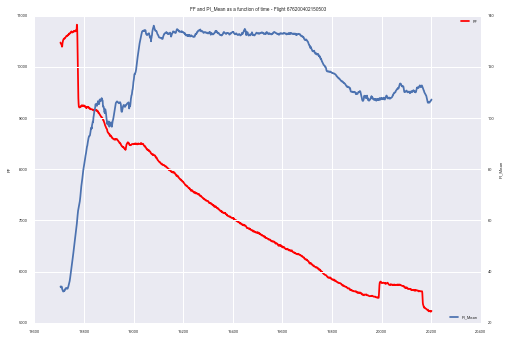

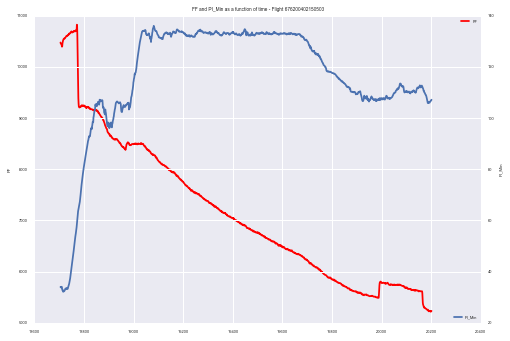

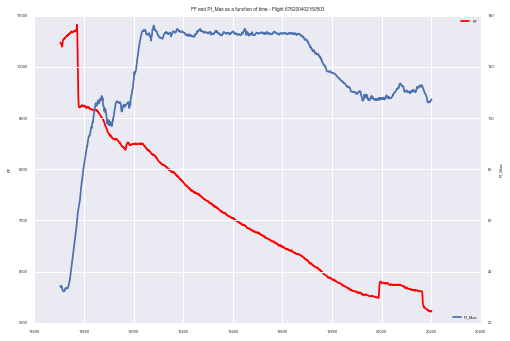

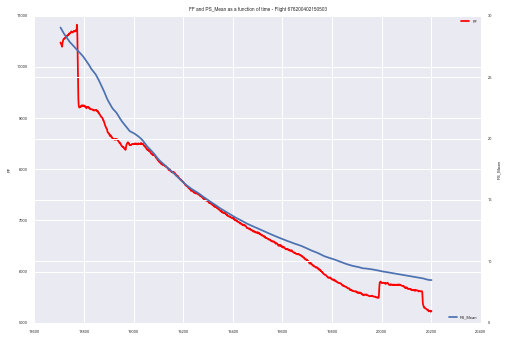

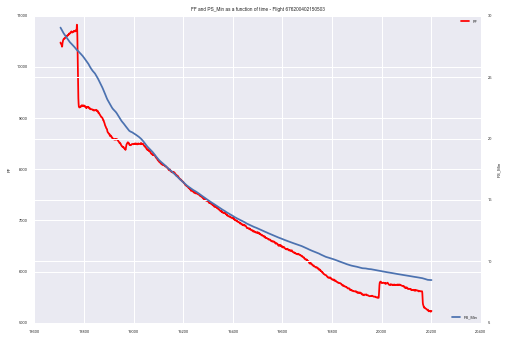

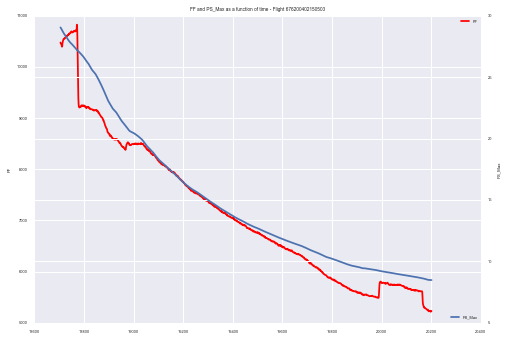

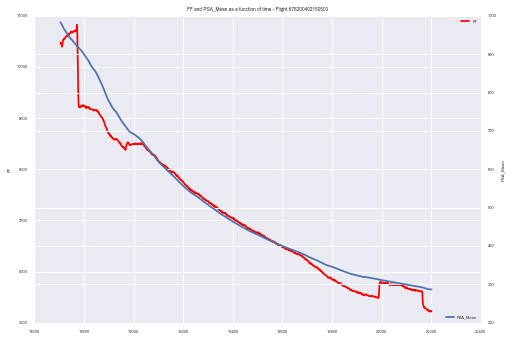

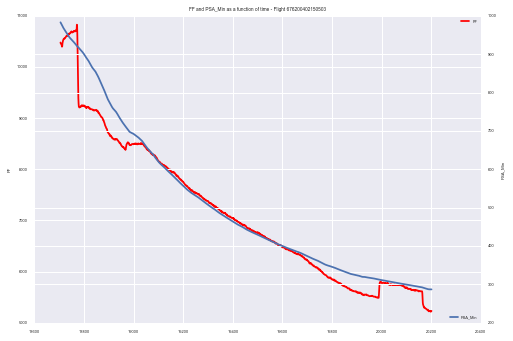

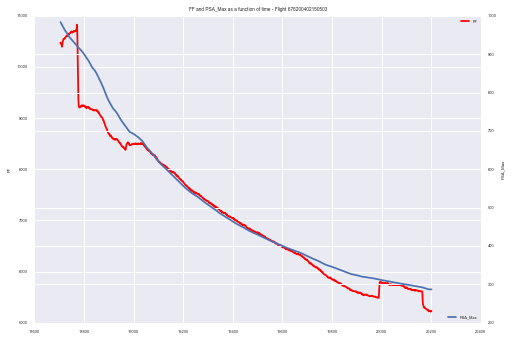

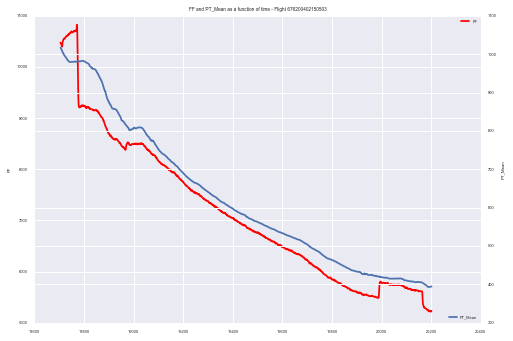

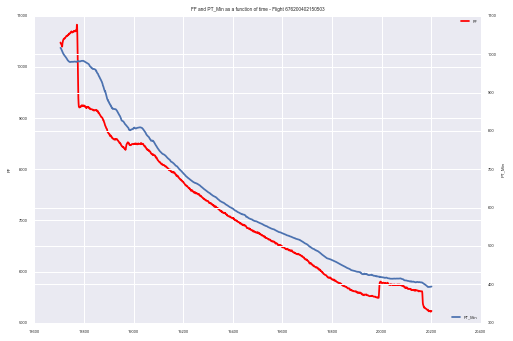

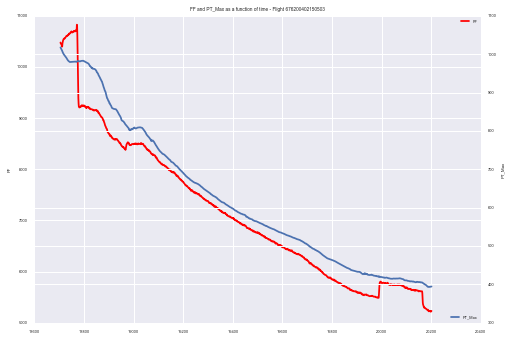

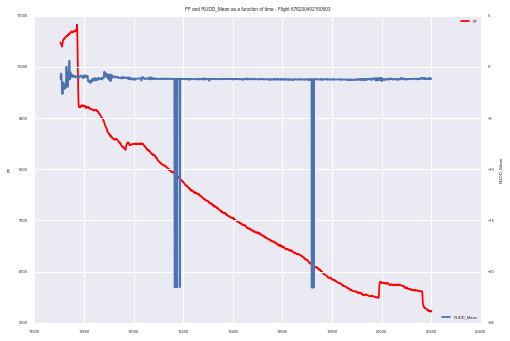

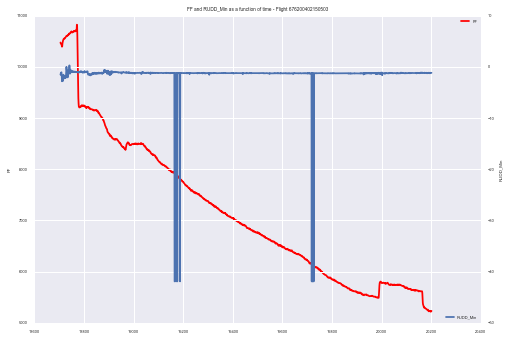

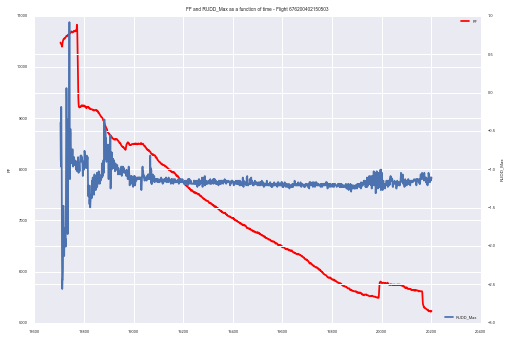

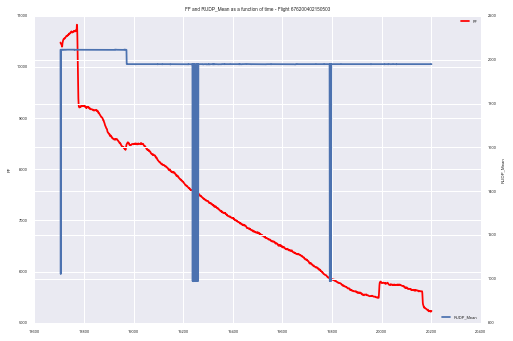

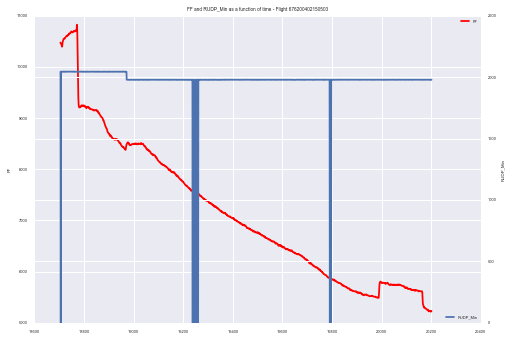

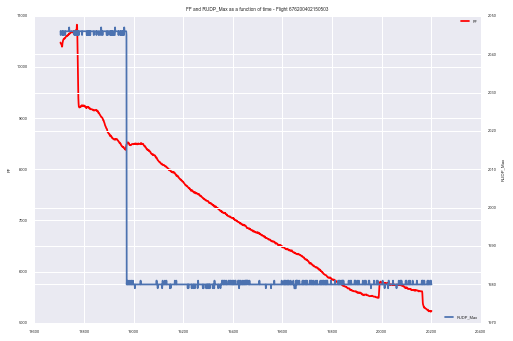

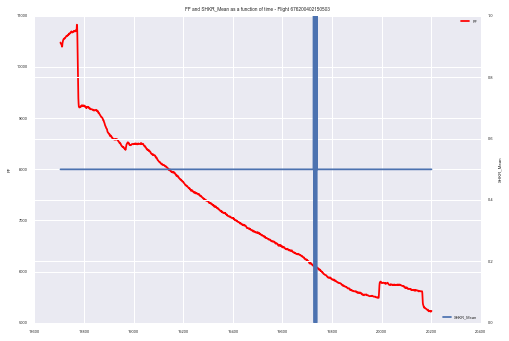

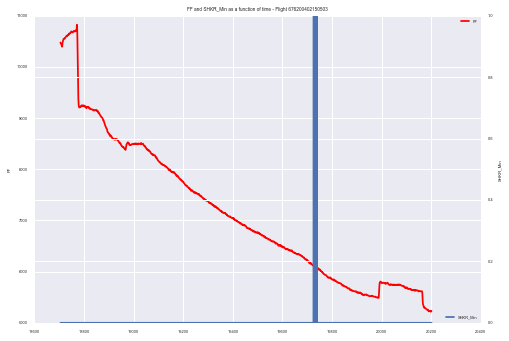

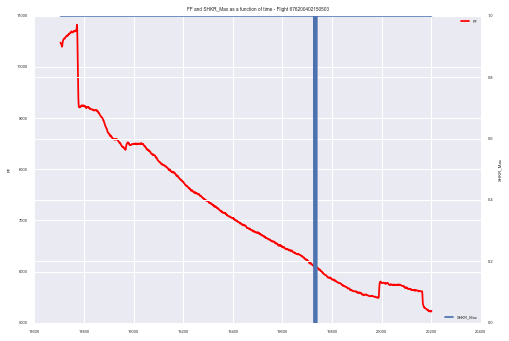

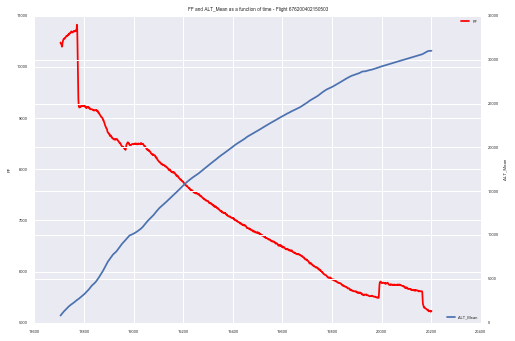

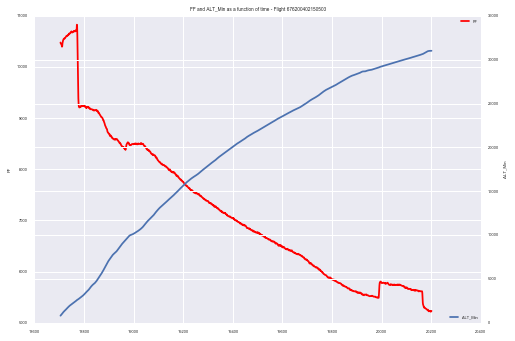

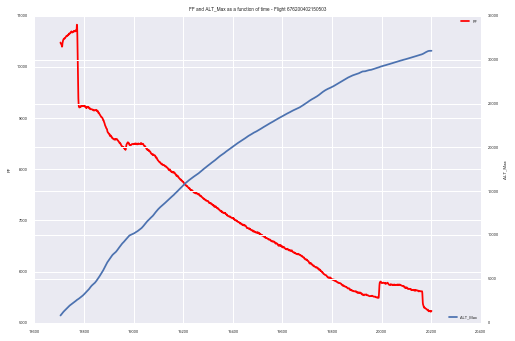

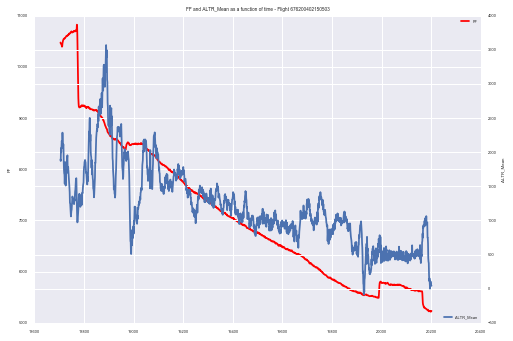

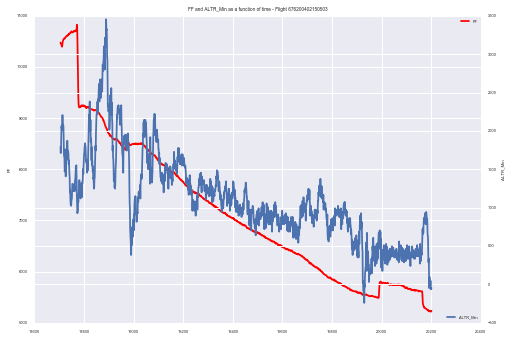

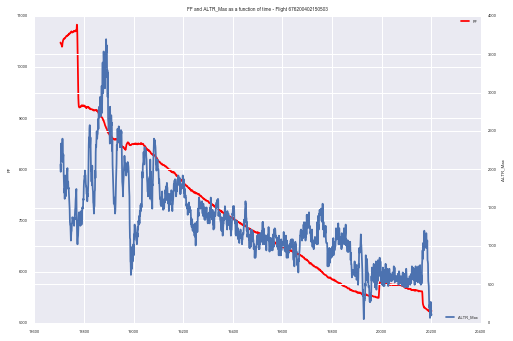

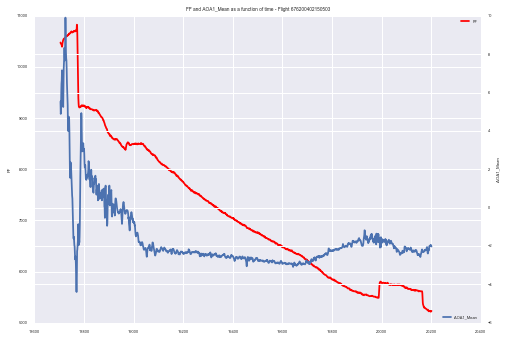

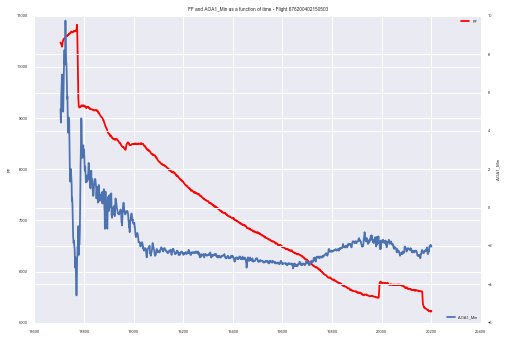

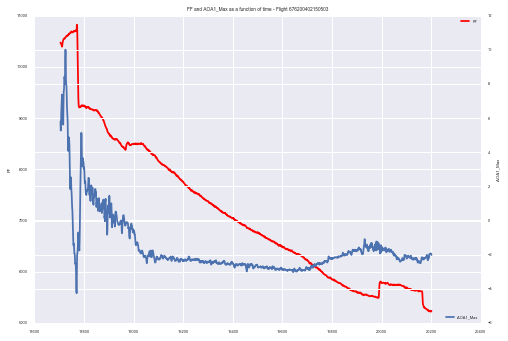

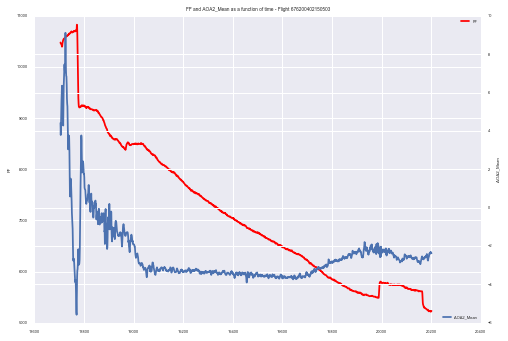

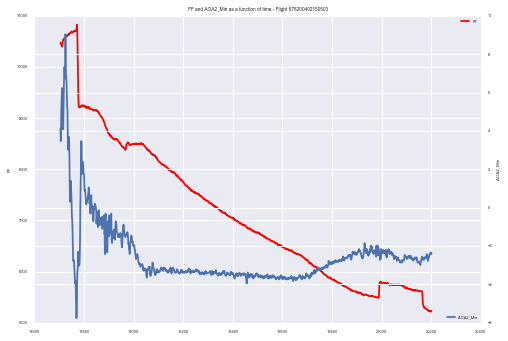

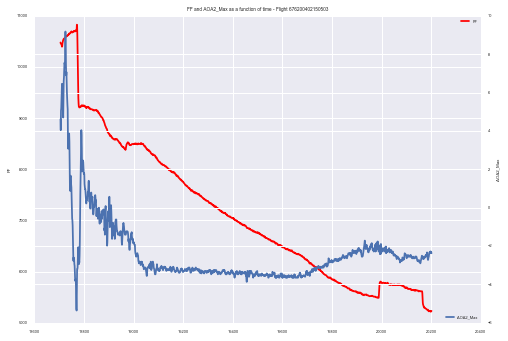

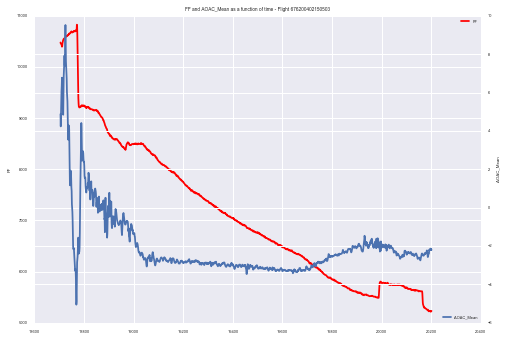

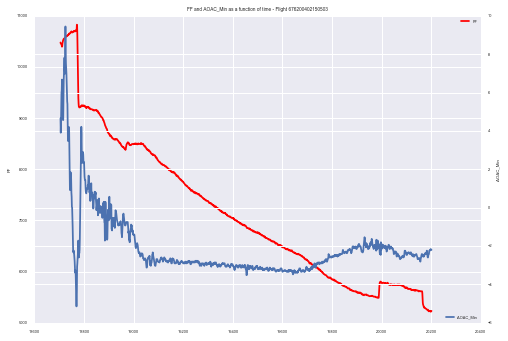

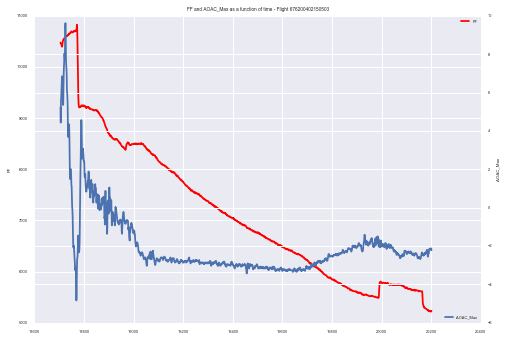

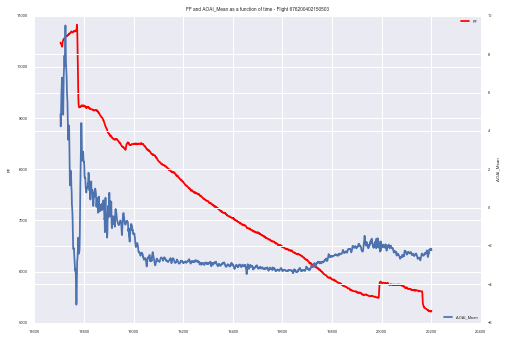

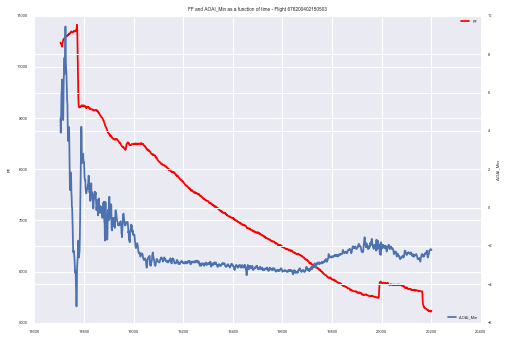

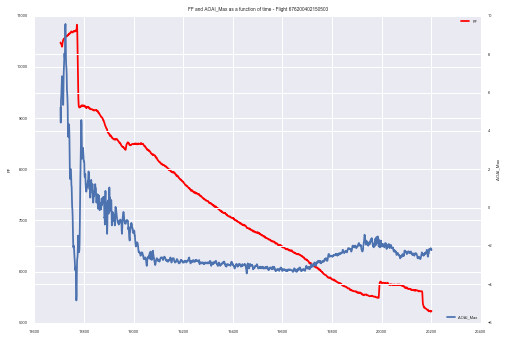

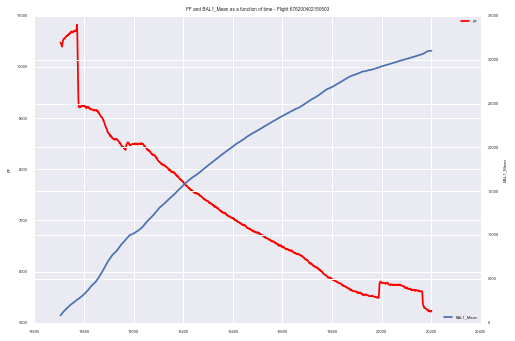

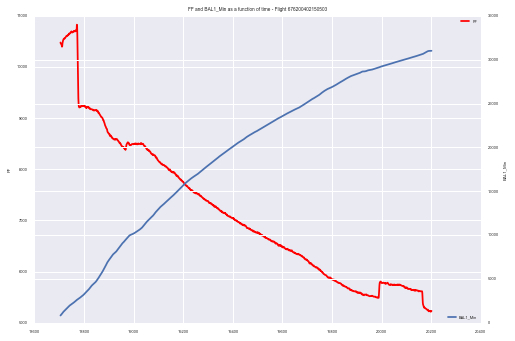

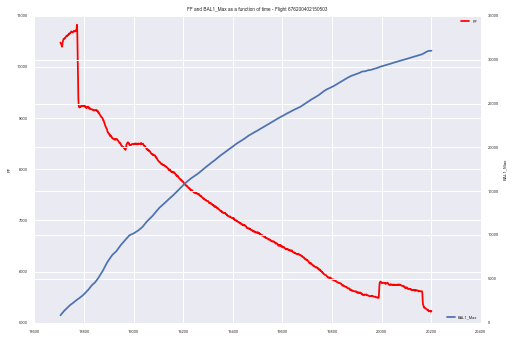

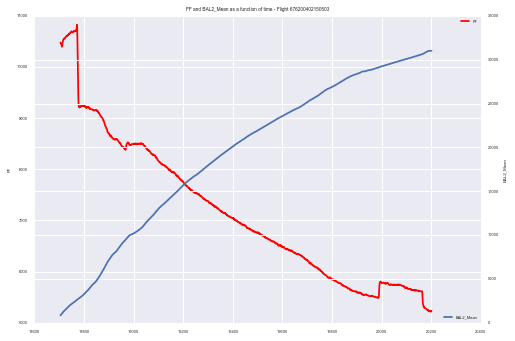

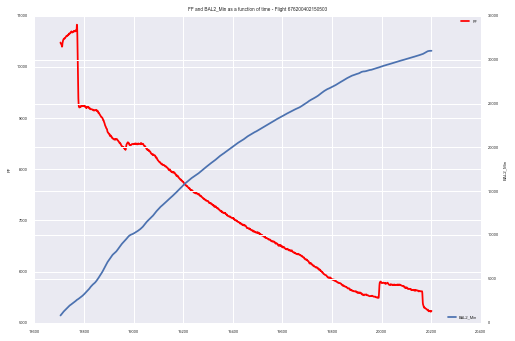

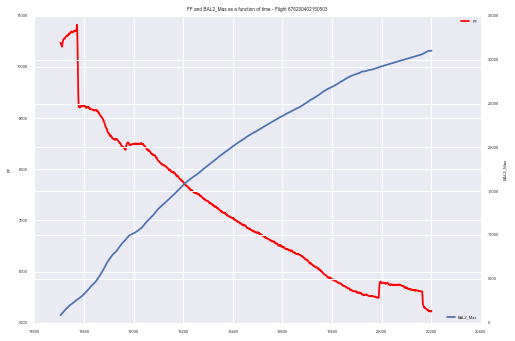

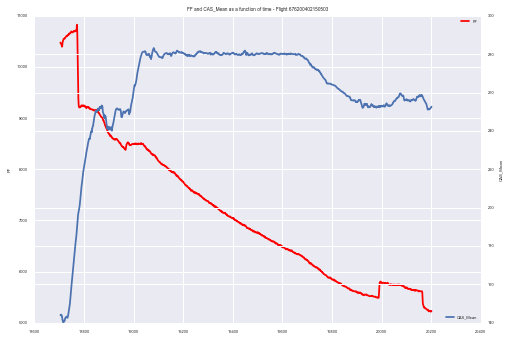

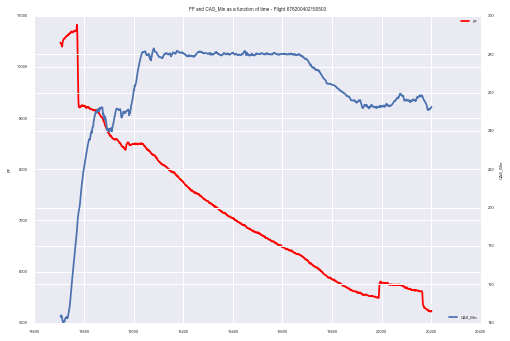

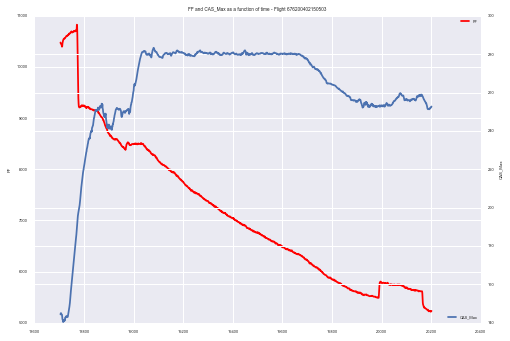

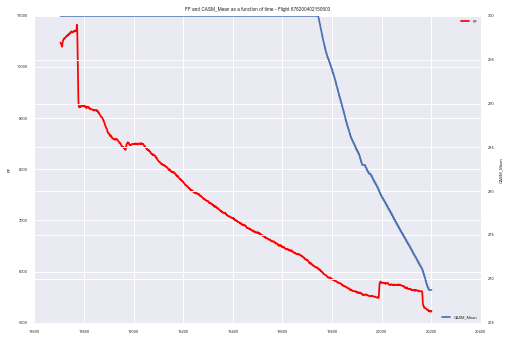

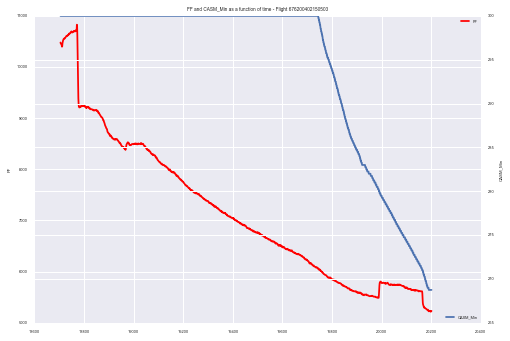

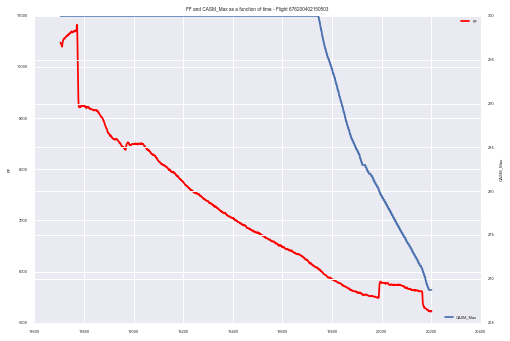

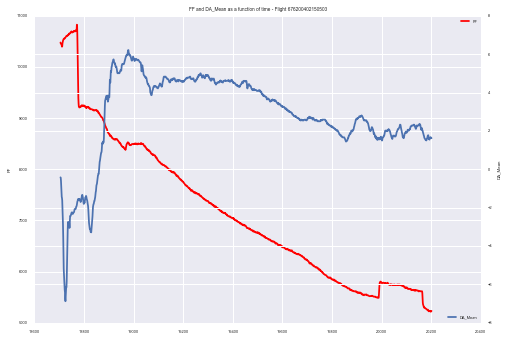

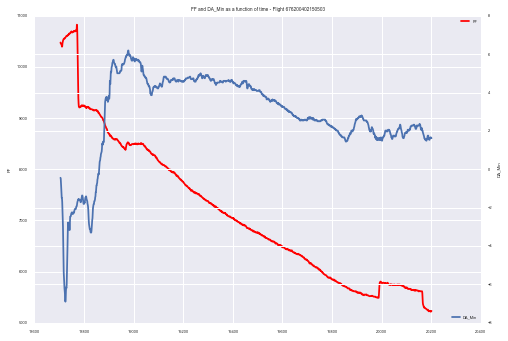

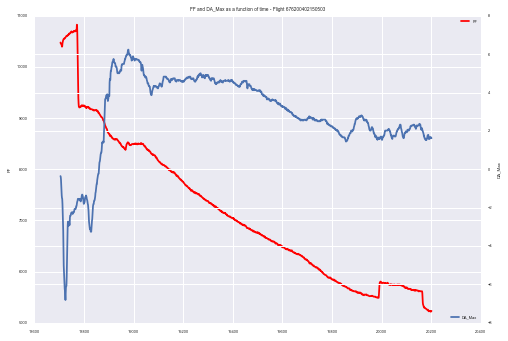

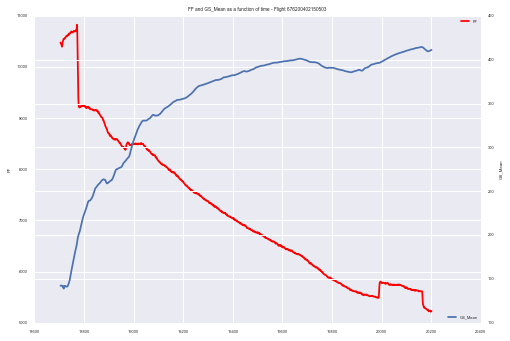

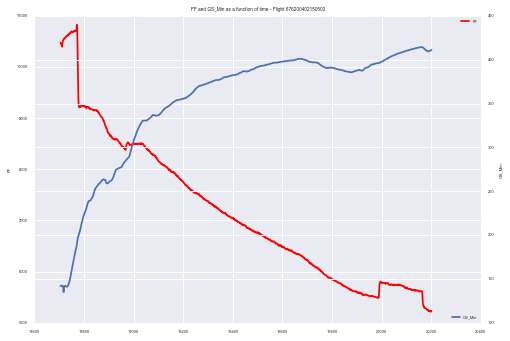

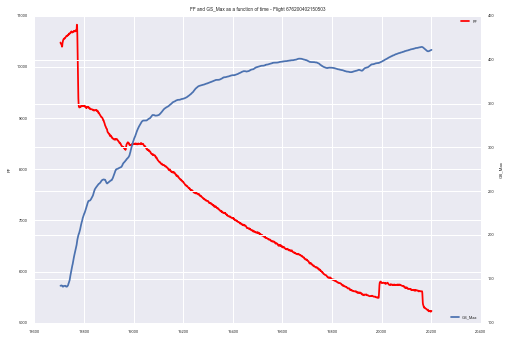

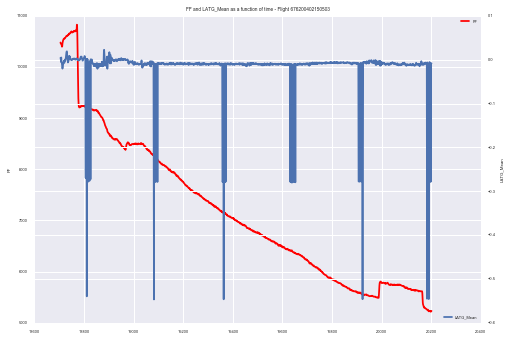

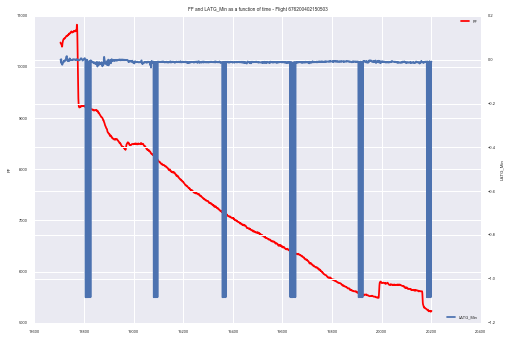

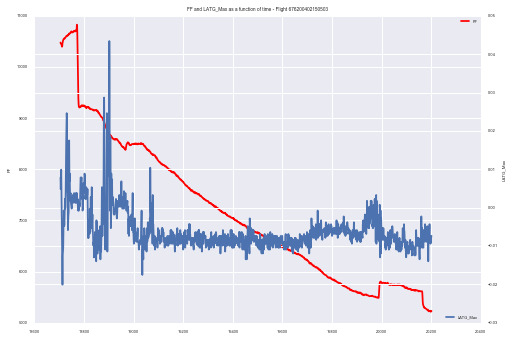

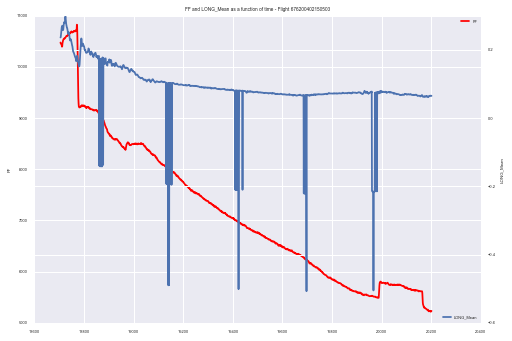

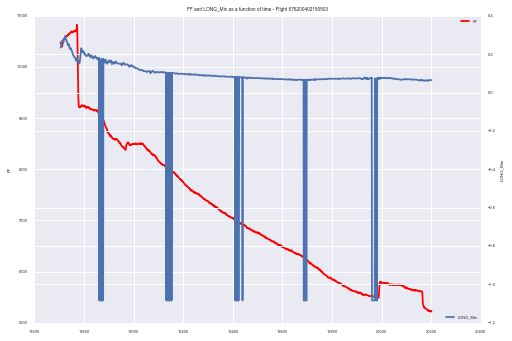

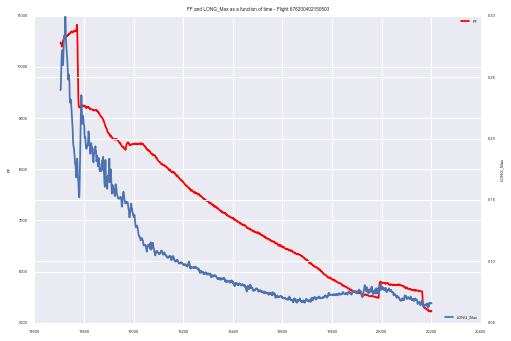

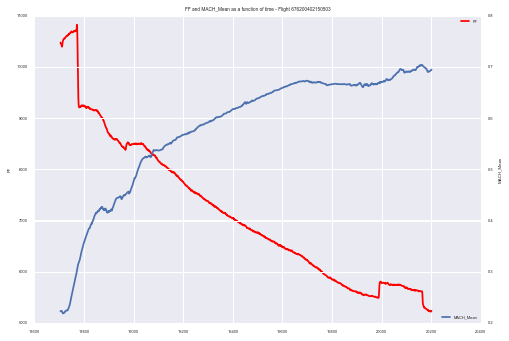

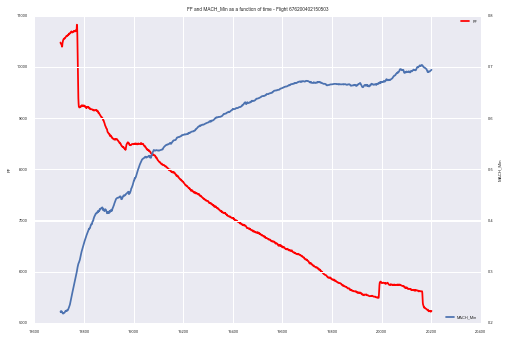

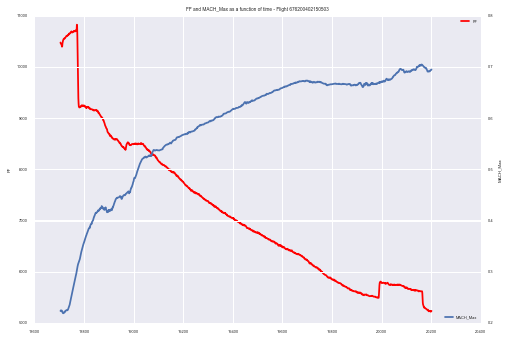

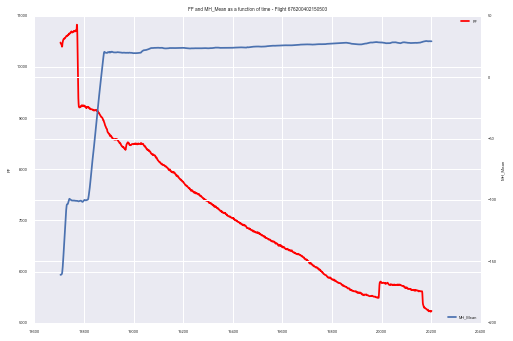

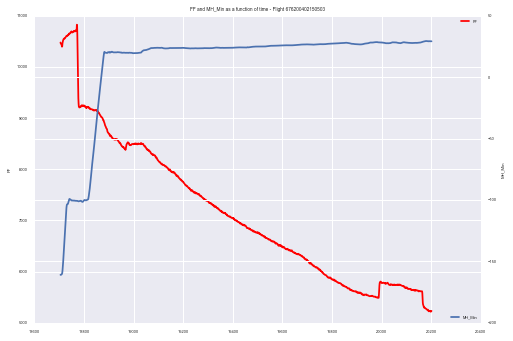

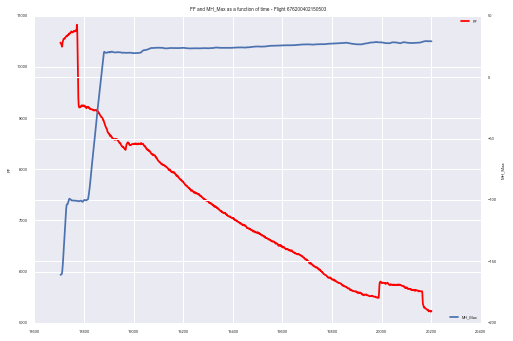

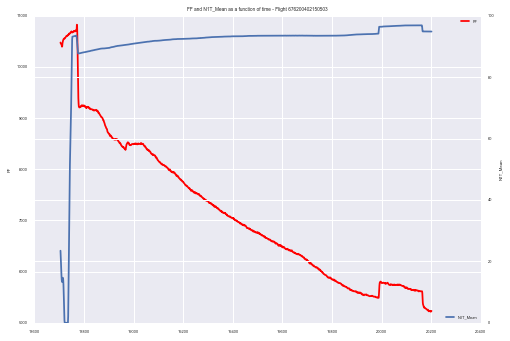

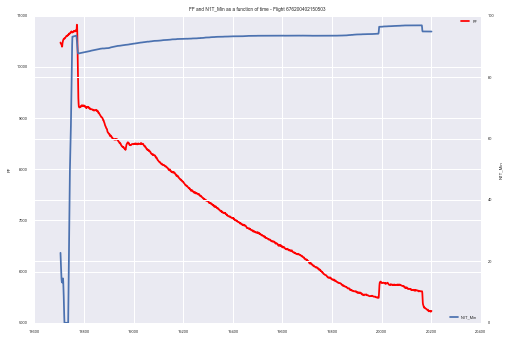

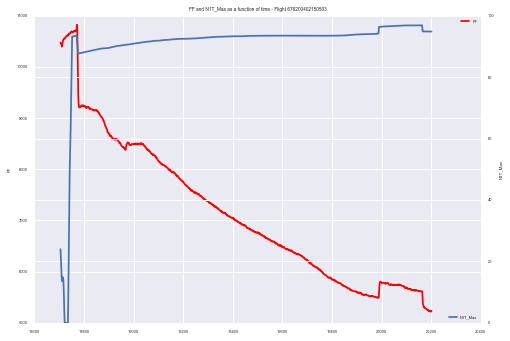

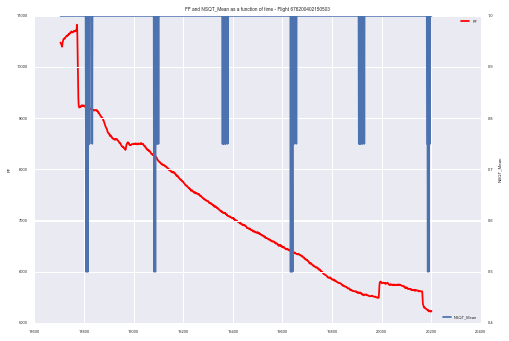

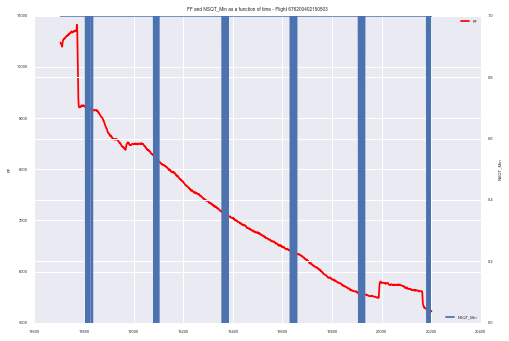

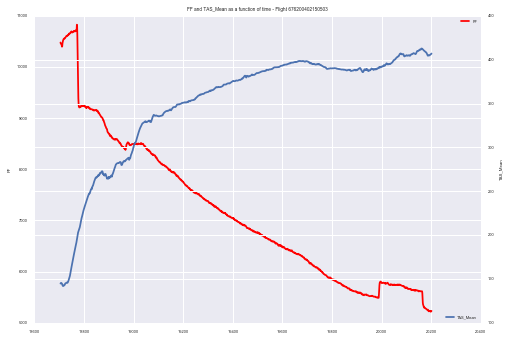

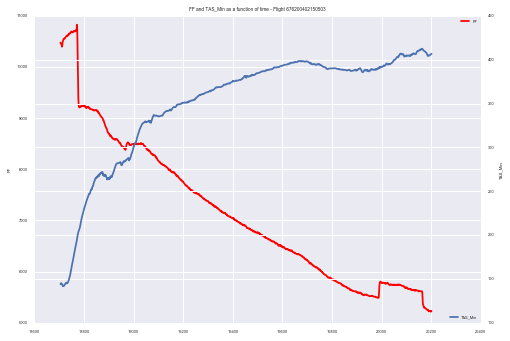

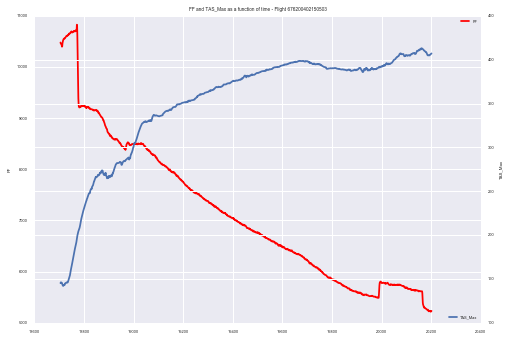

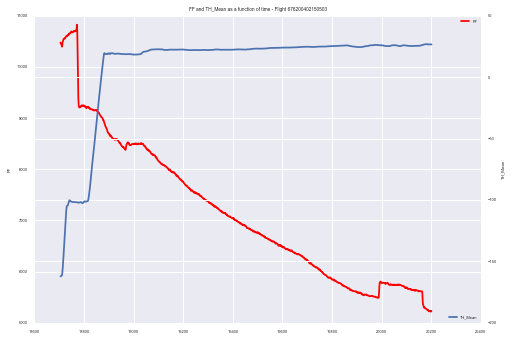

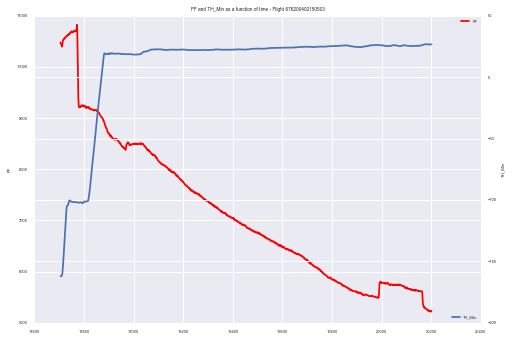

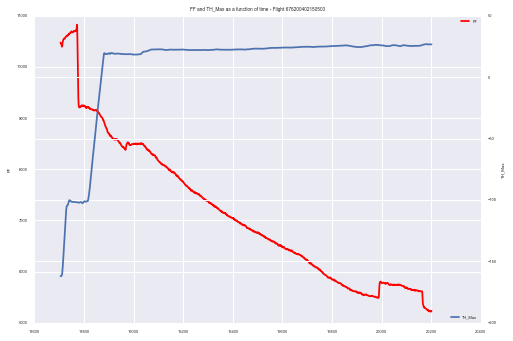

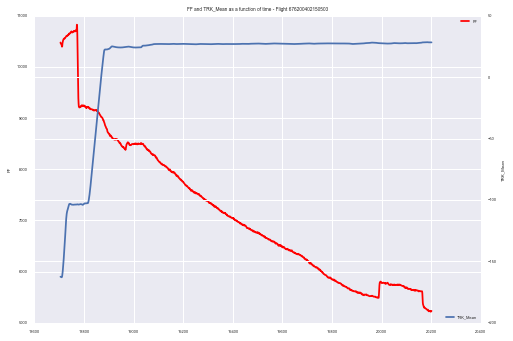

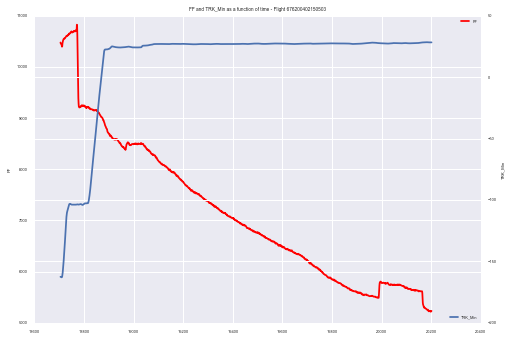

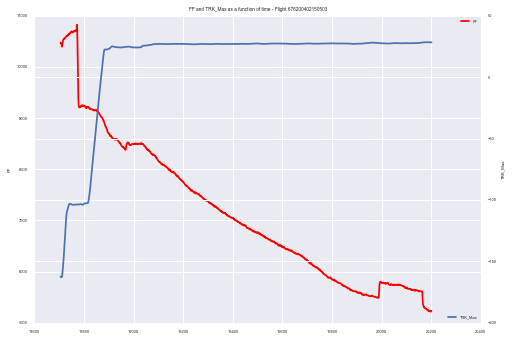

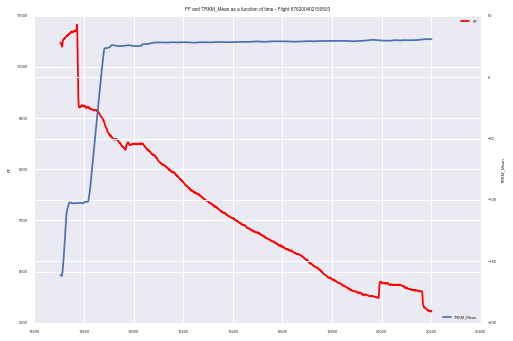

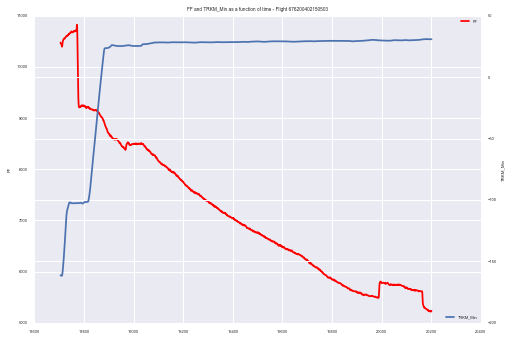

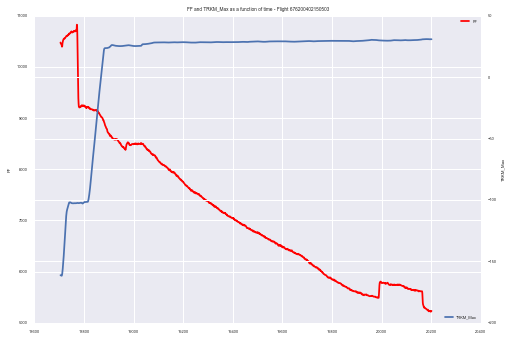

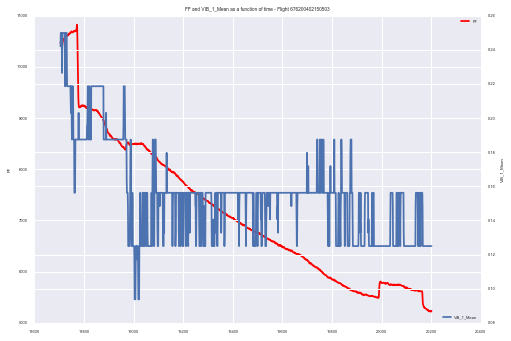

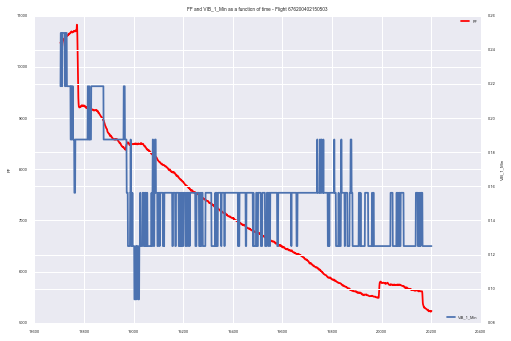

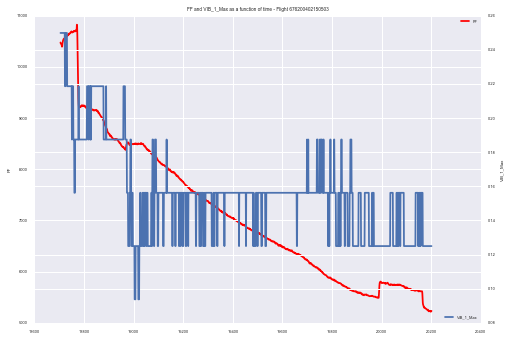

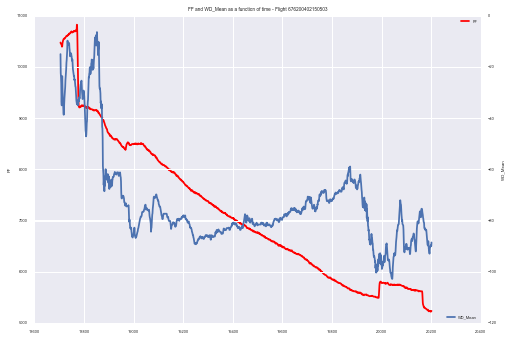

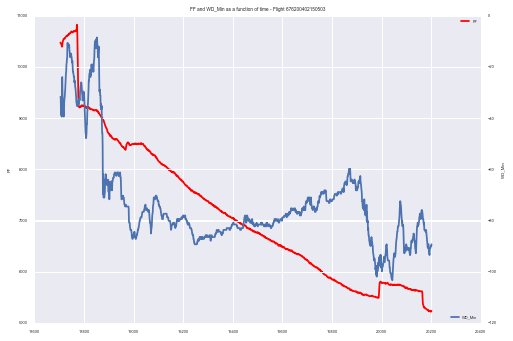

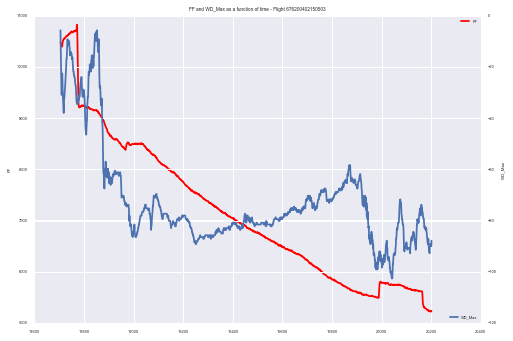

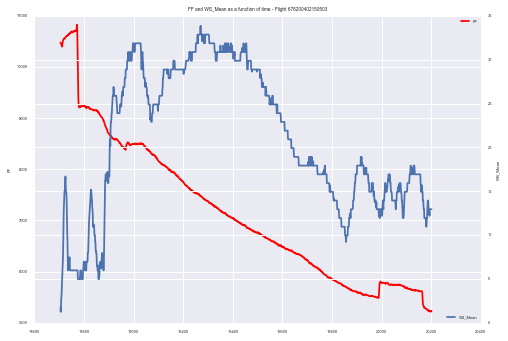

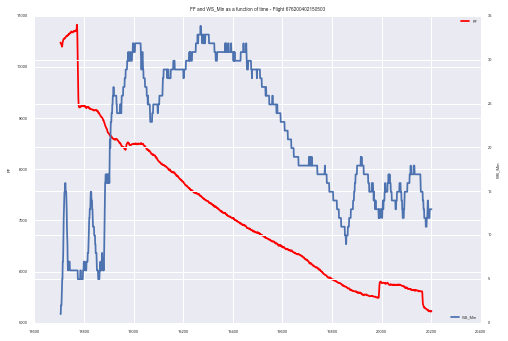

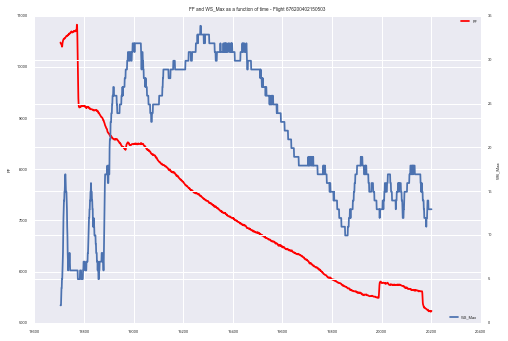

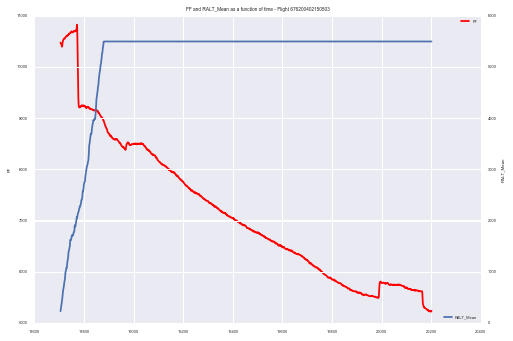

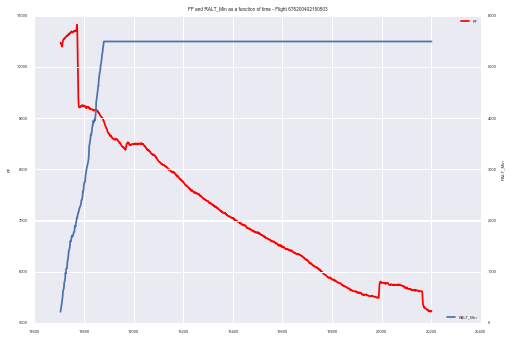

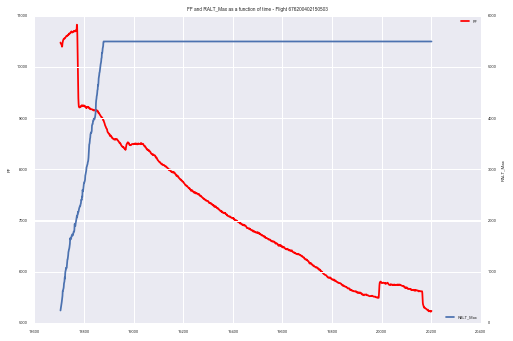

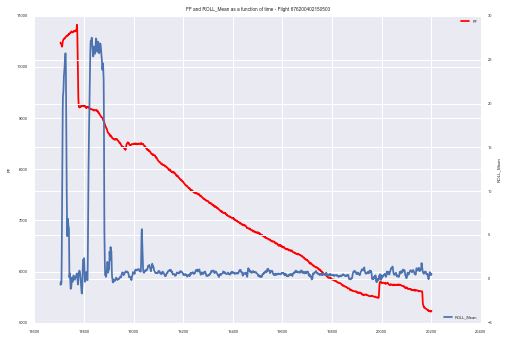

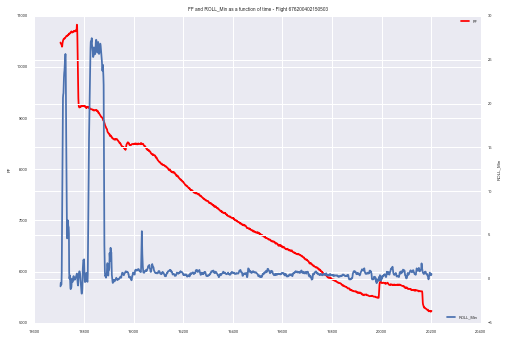

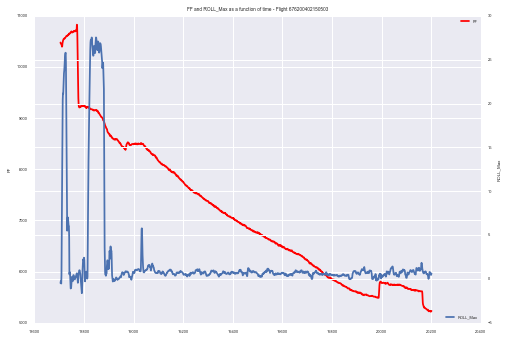

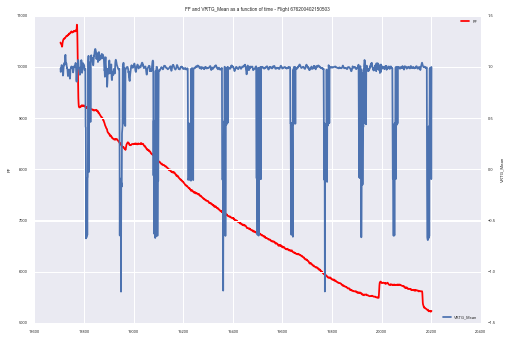

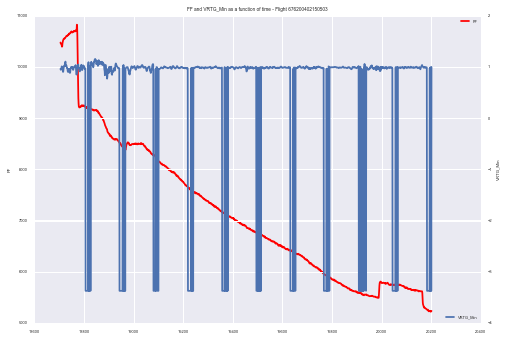

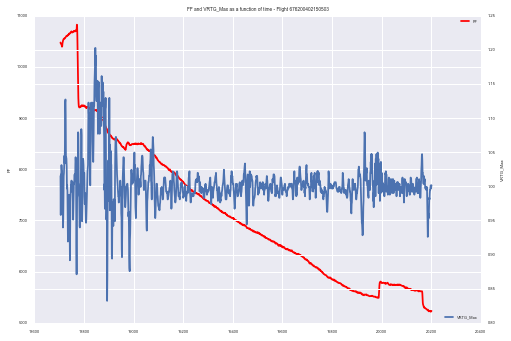

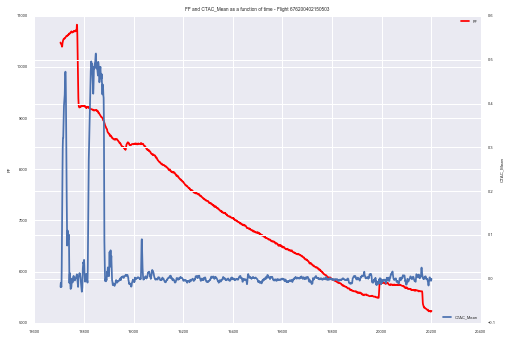

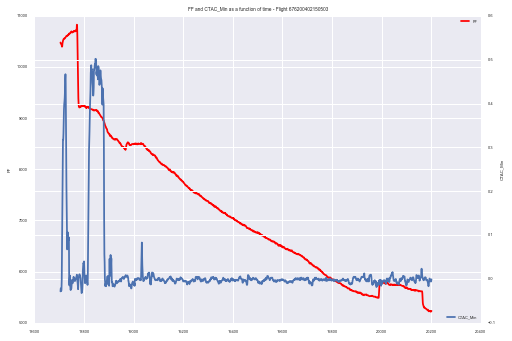

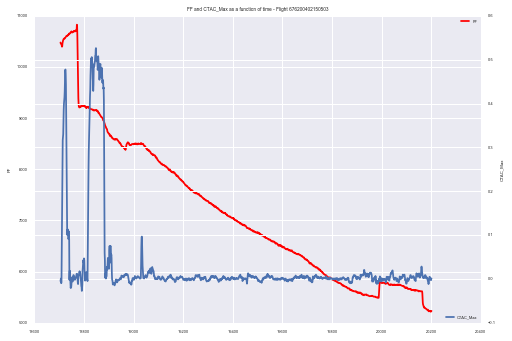

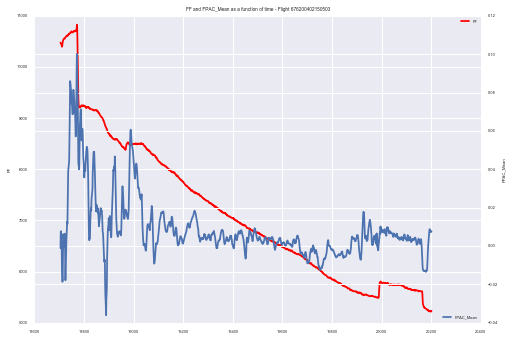

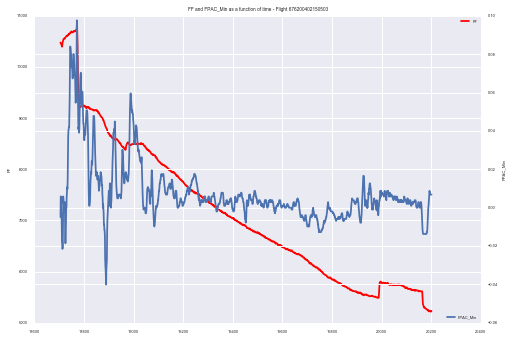

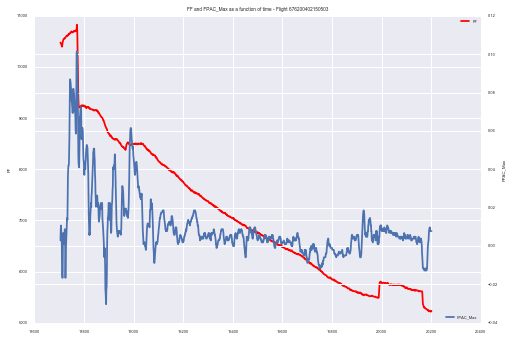

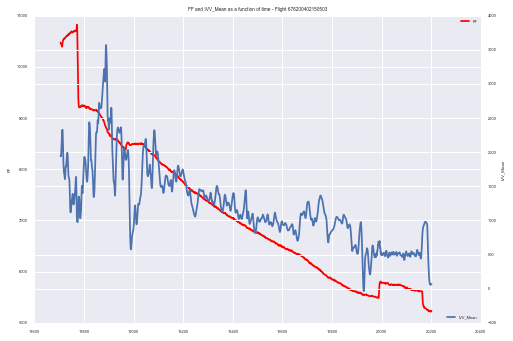

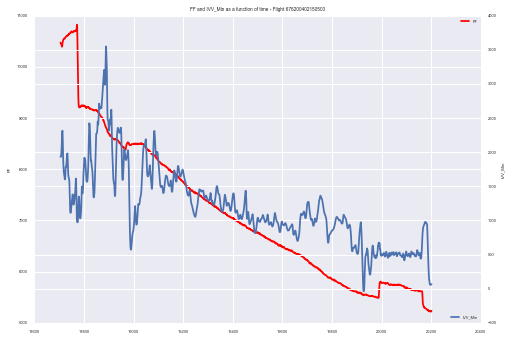

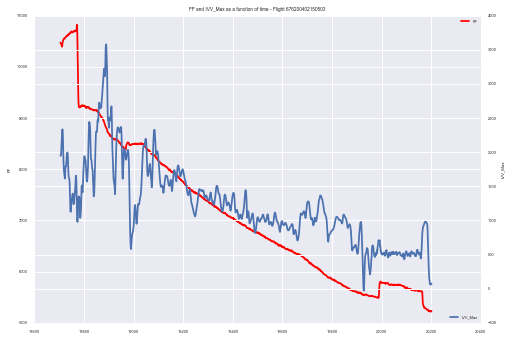

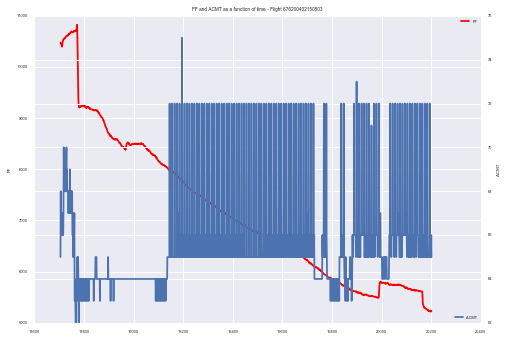

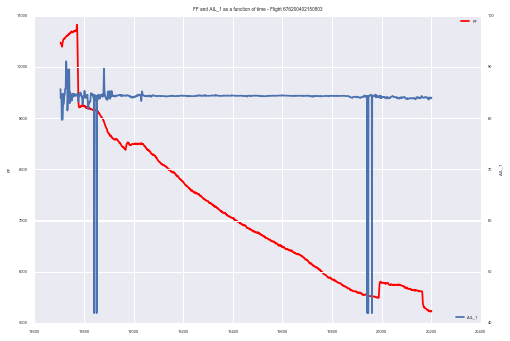

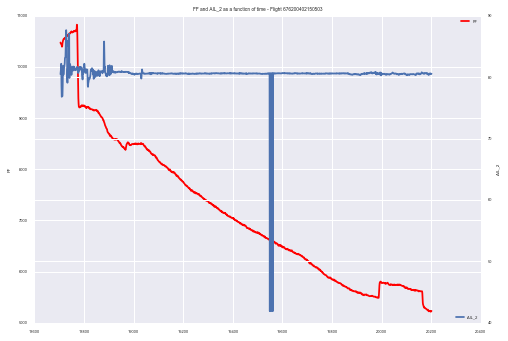

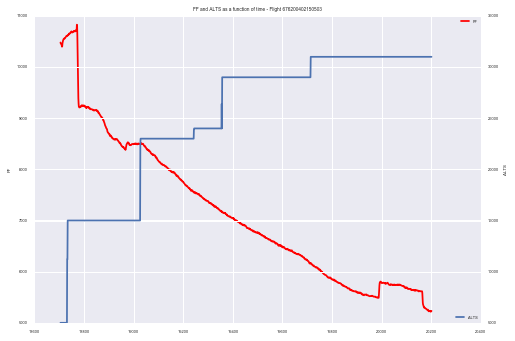

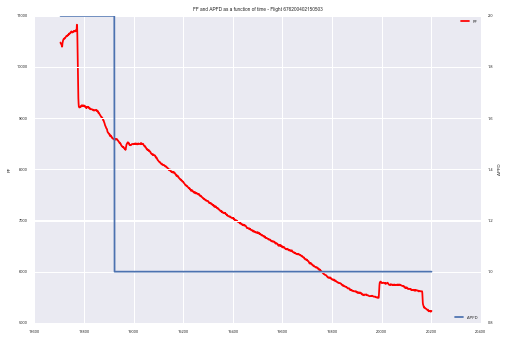

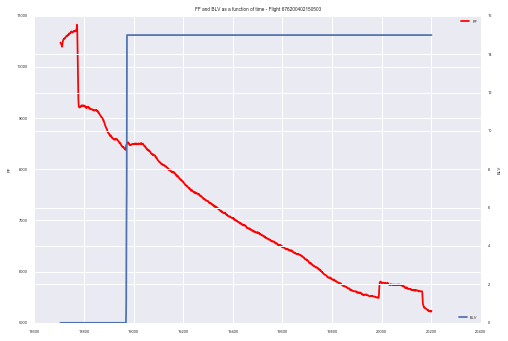

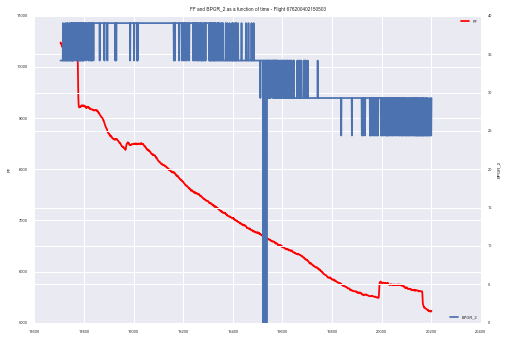

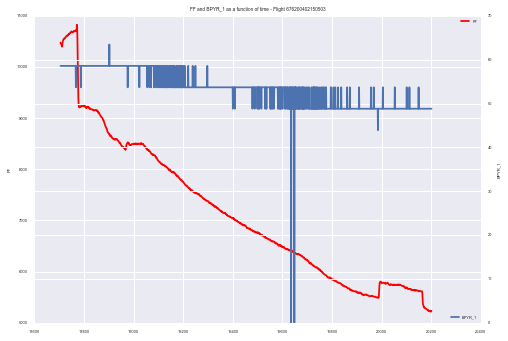

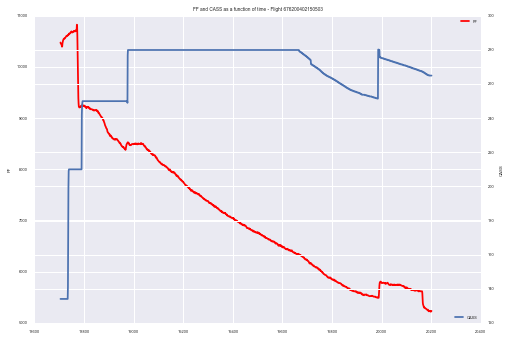

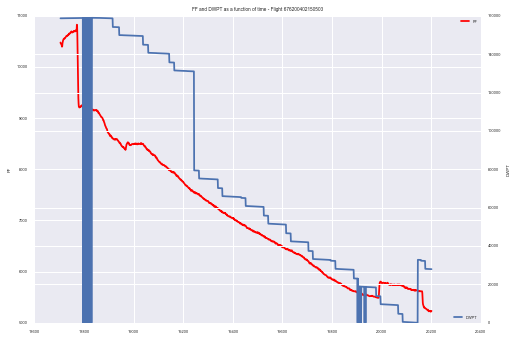

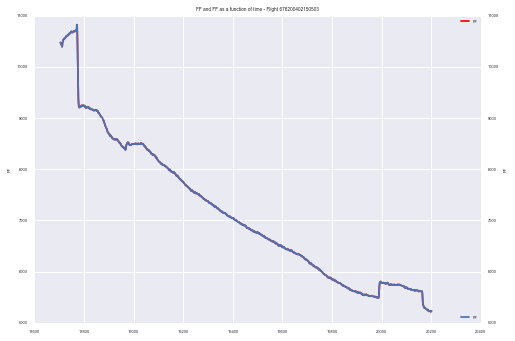

In [46]:
pdf = matplotlib.backends.backend_pdf.PdfPages("E:\data\output2_phase4.pdf")
for feature in flight_features:
    if feature not in list_of_vars_close_to_zero:
        make_dual_plot(feature, 6)
        
pdf.close()

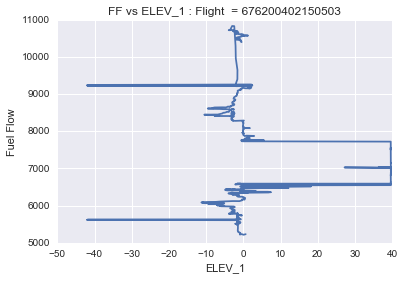

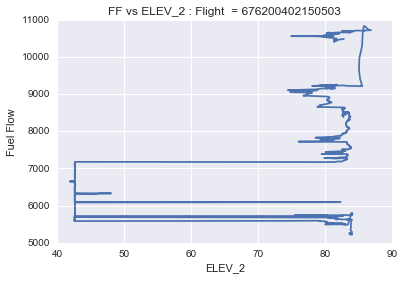

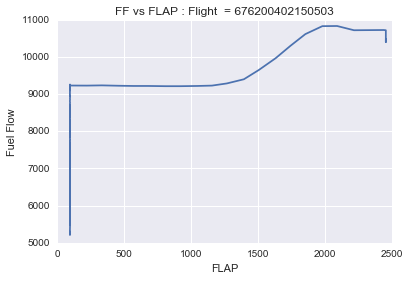

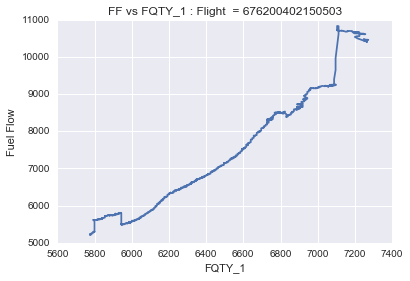

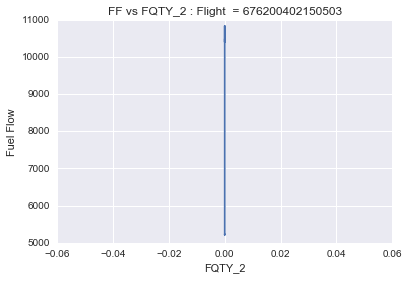

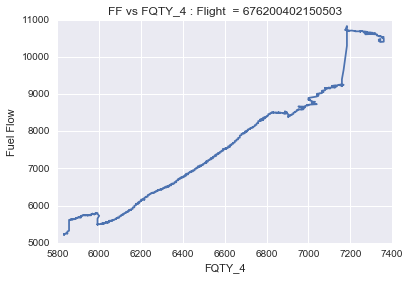

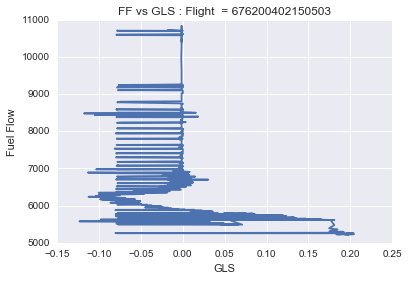

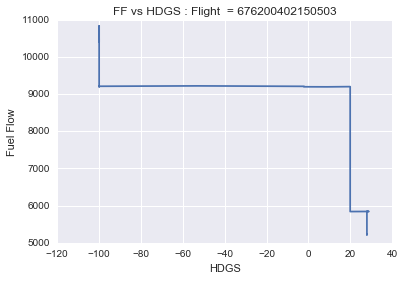

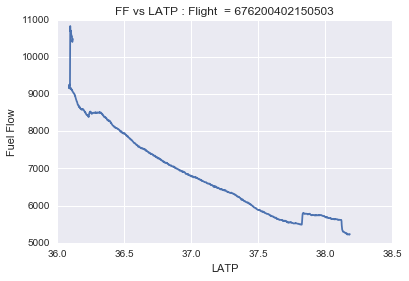

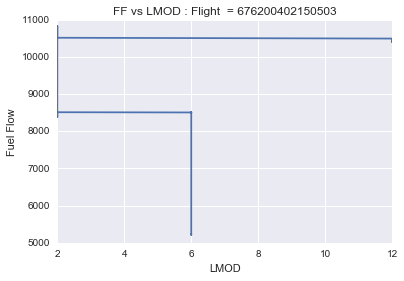

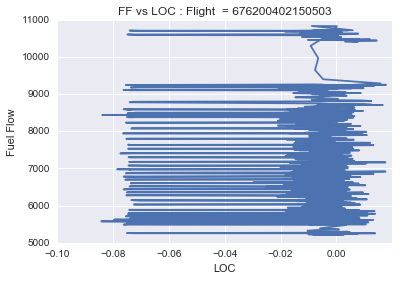

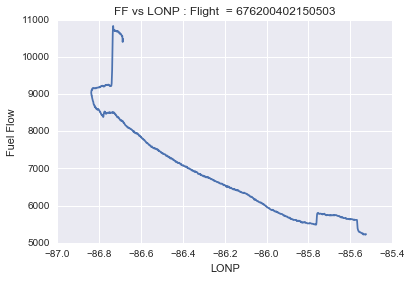

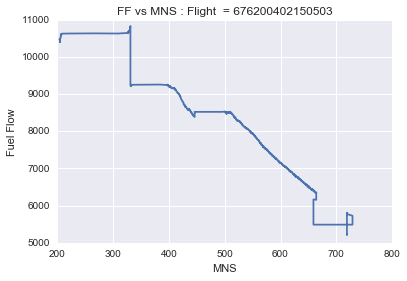

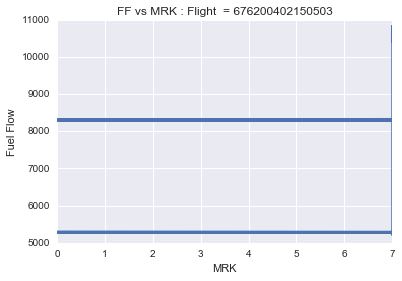

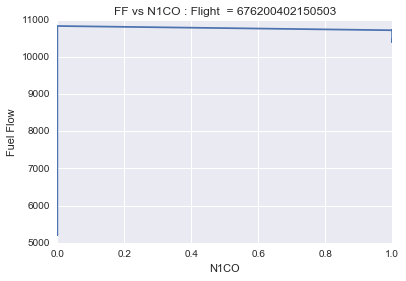

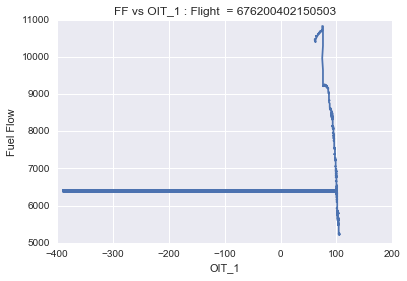

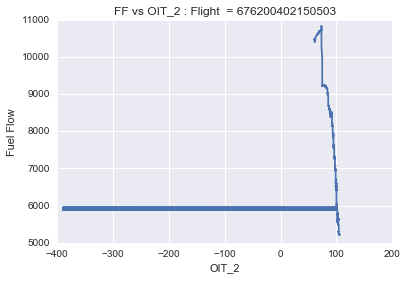

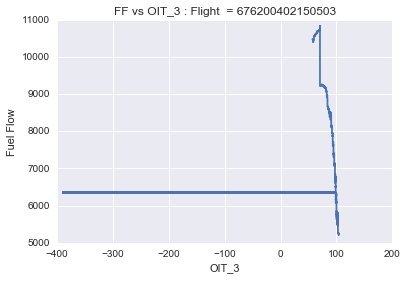

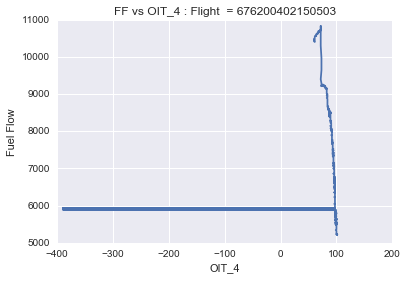

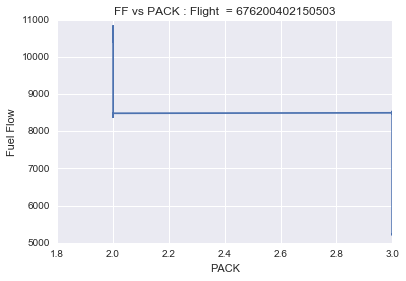

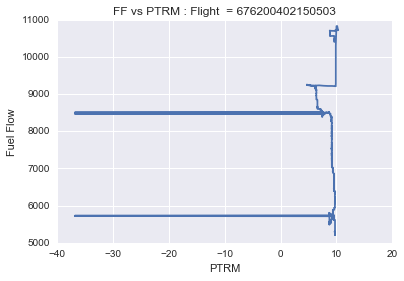

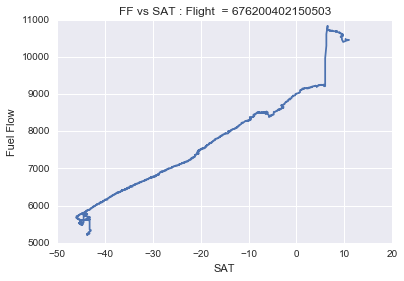

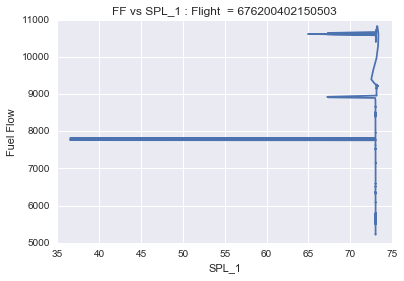

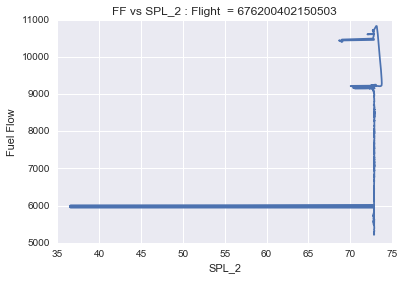

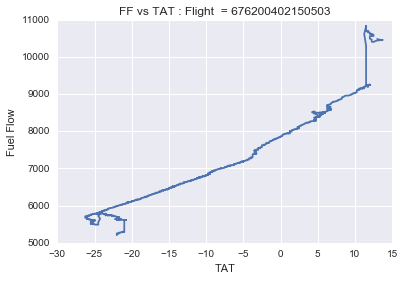

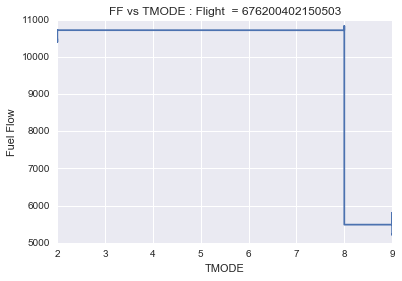

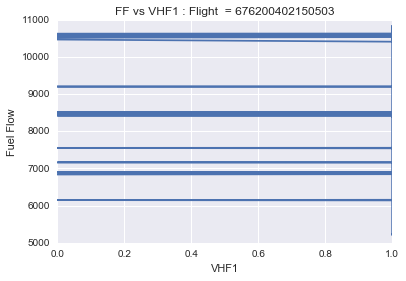

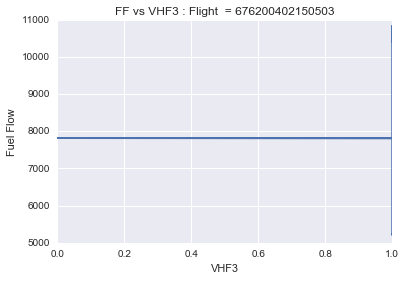

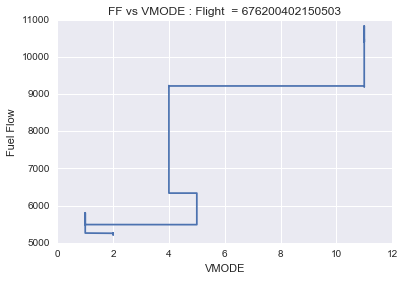

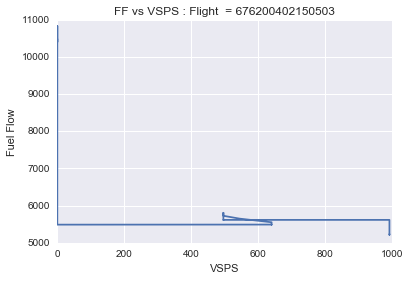

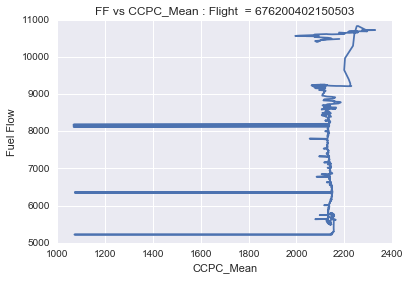

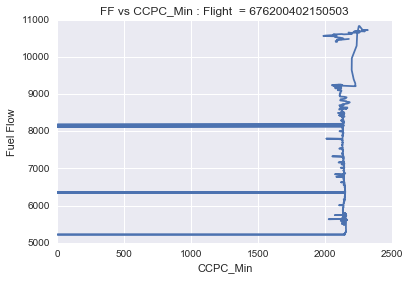

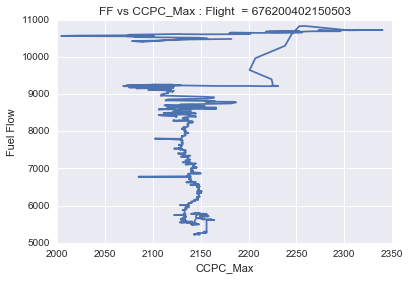

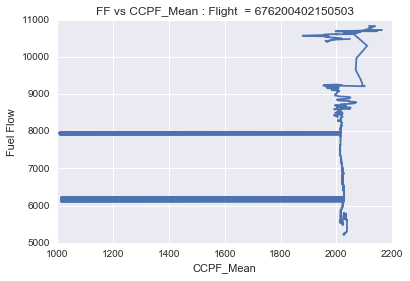

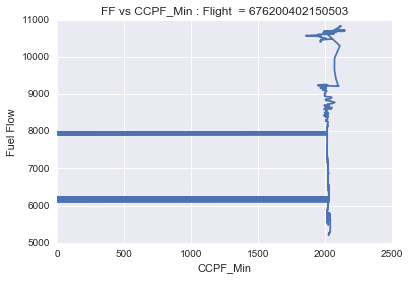

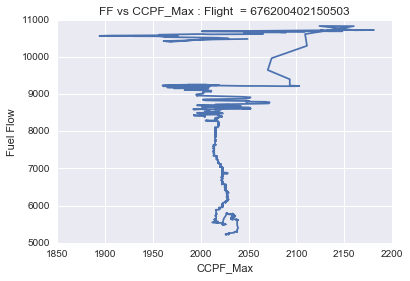

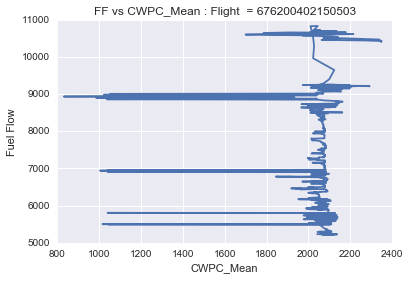

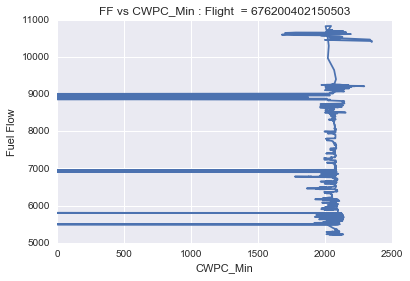

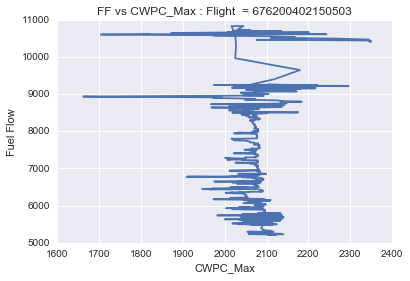

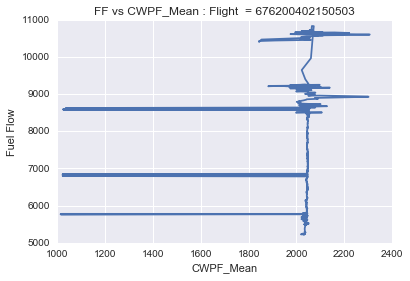

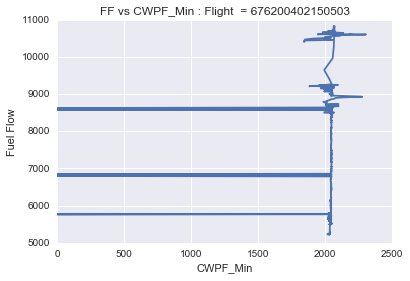

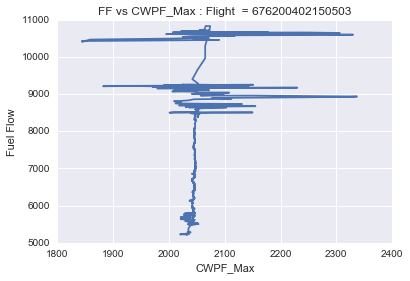

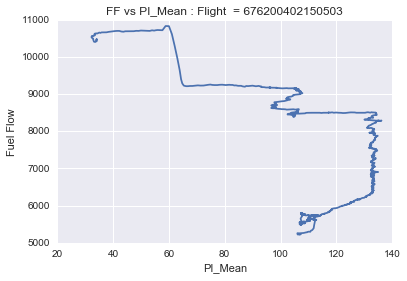

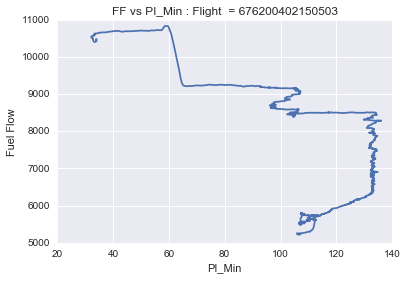

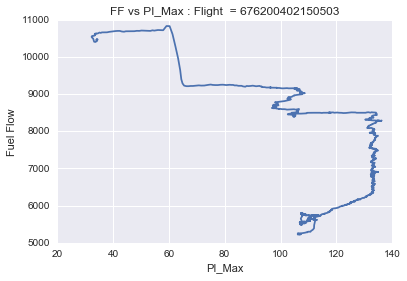

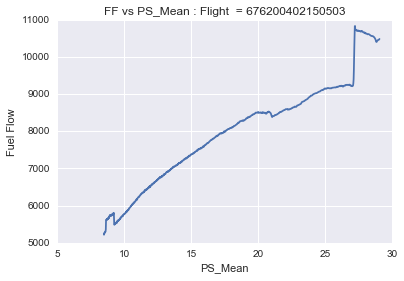

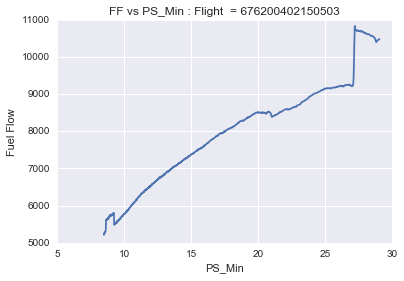

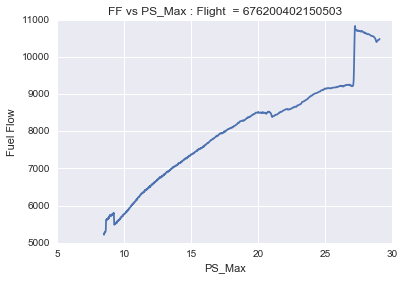

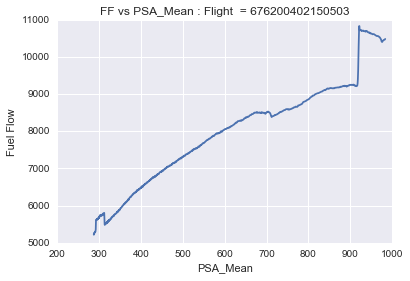

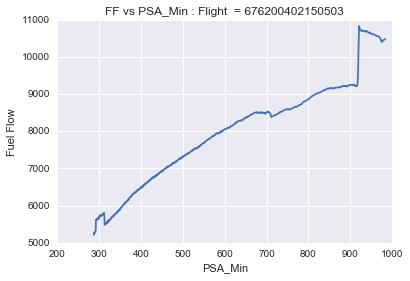

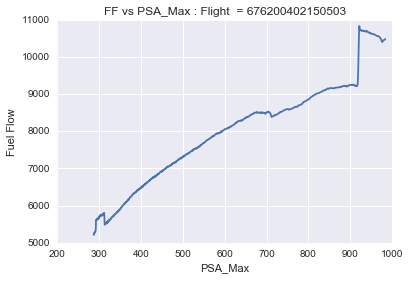

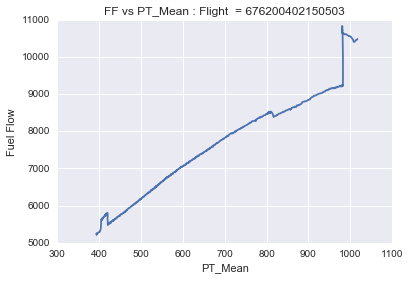

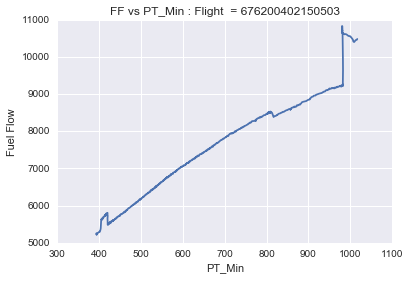

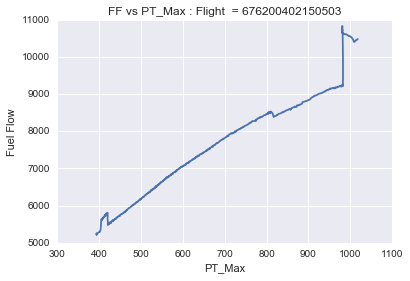

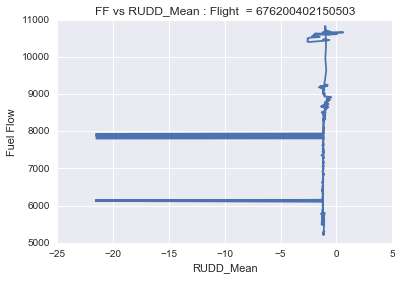

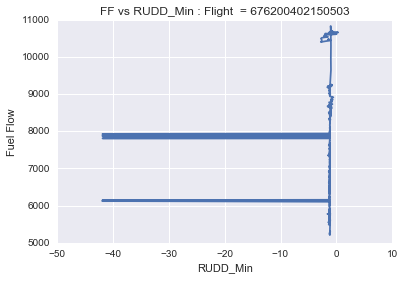

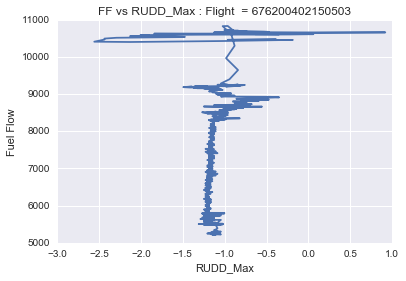

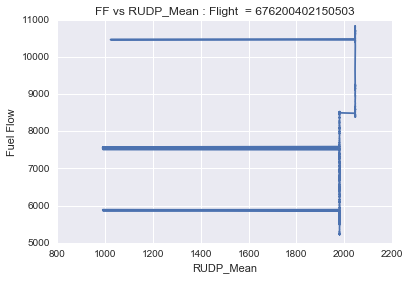

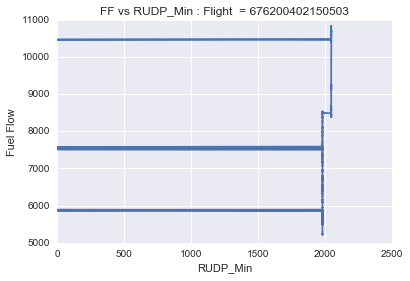

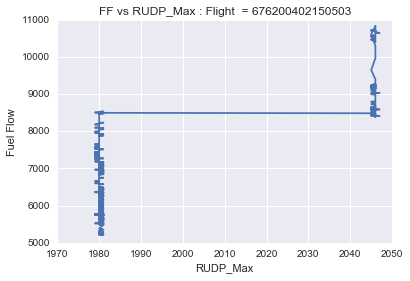

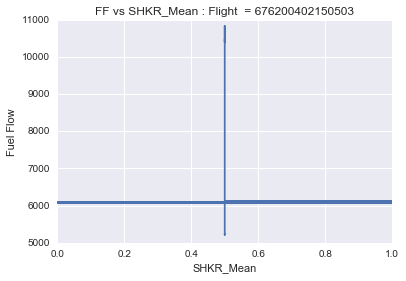

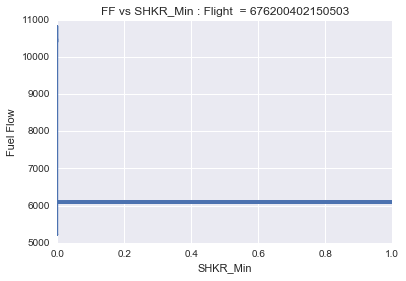

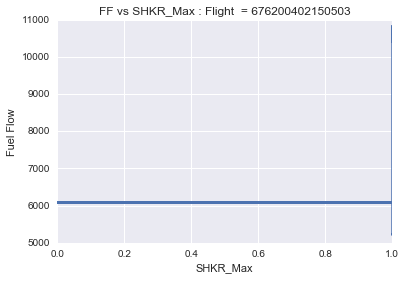

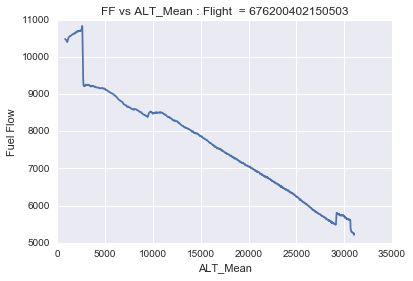

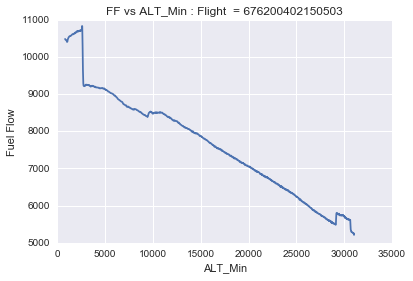

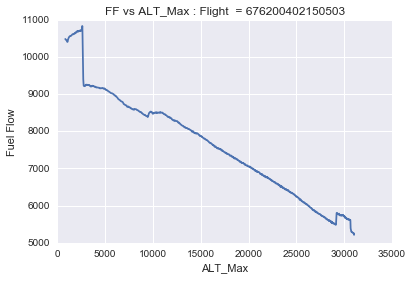

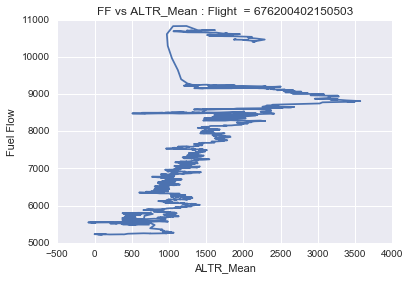

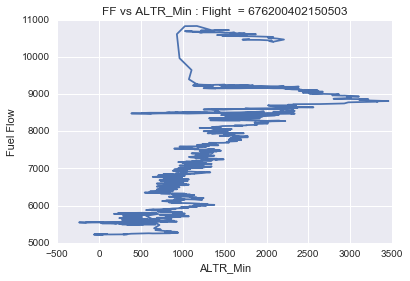

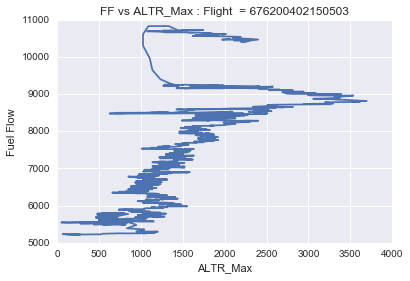

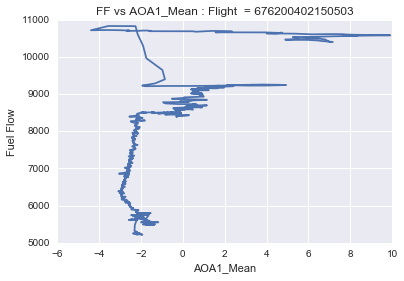

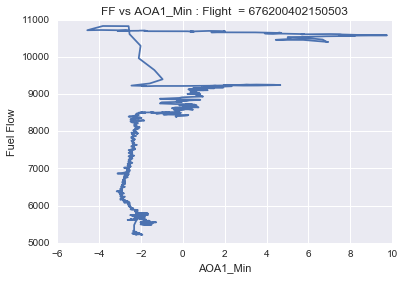

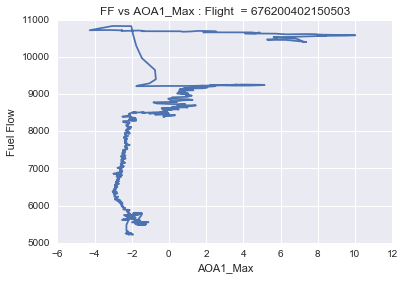

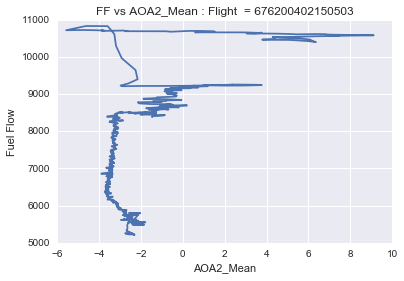

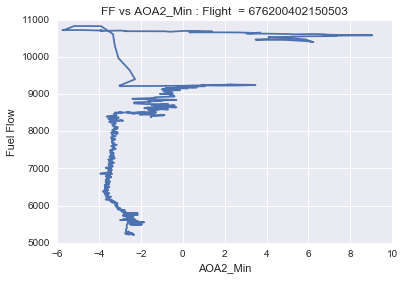

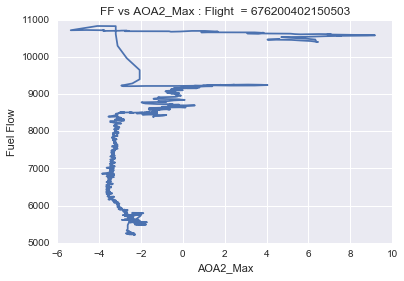

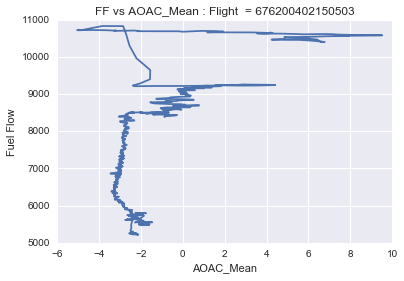

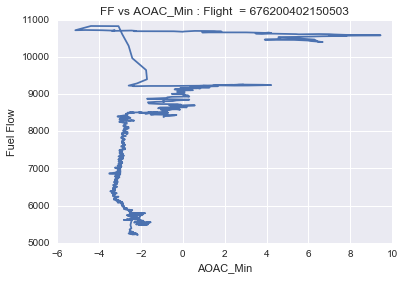

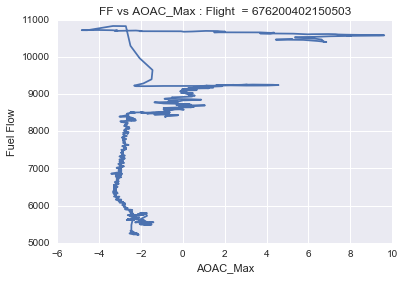

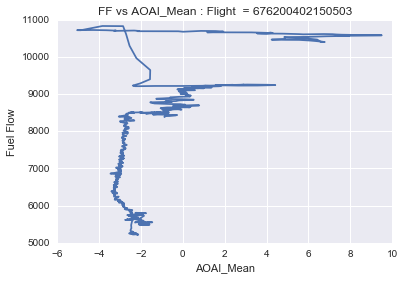

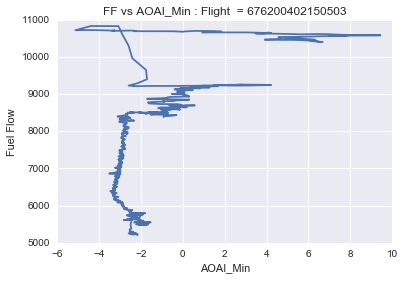

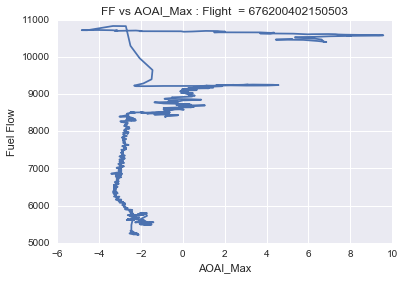

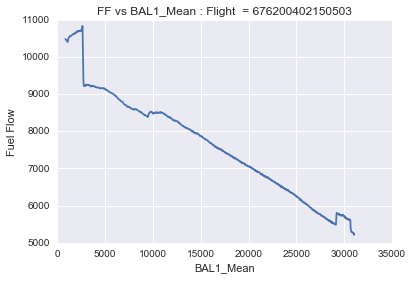

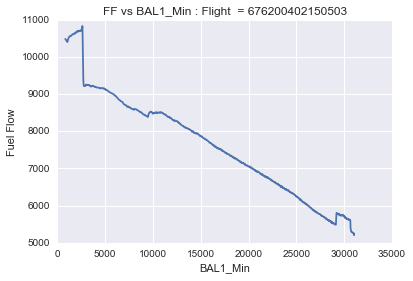

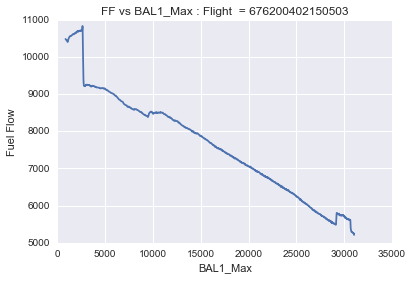

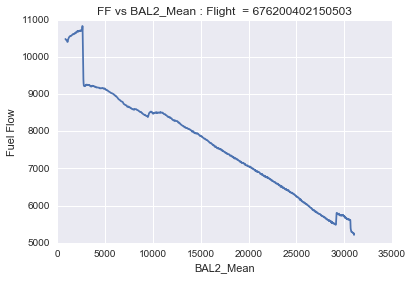

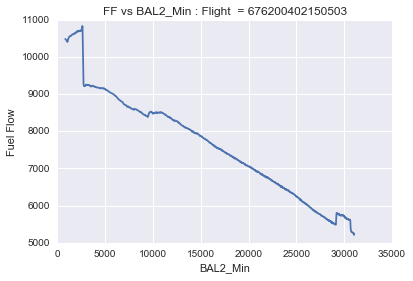

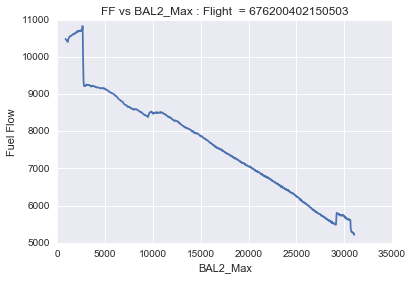

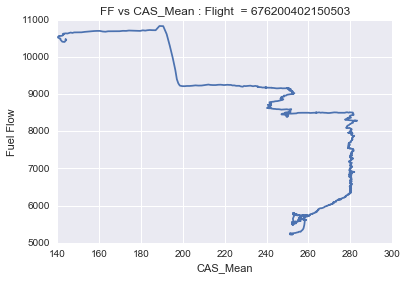

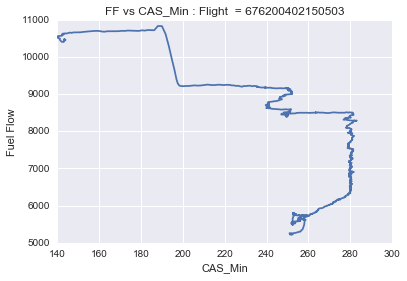

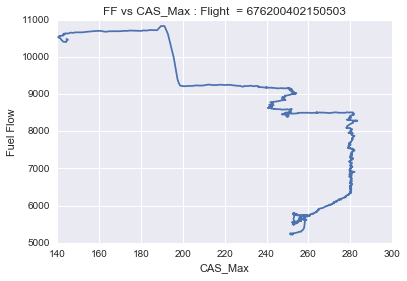

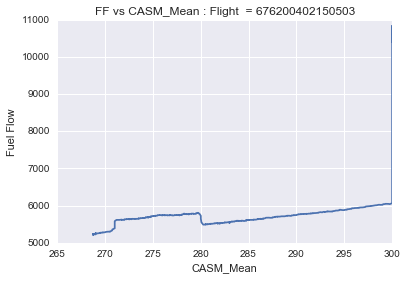

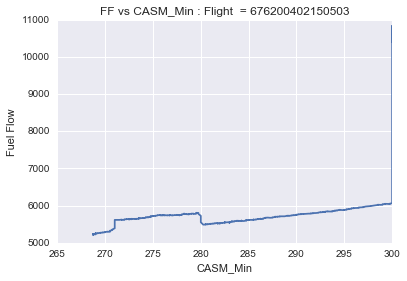

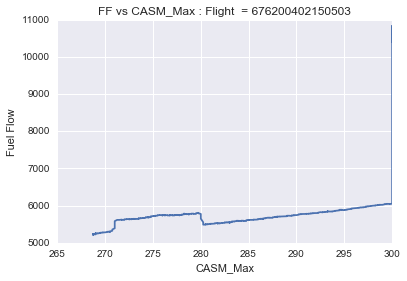

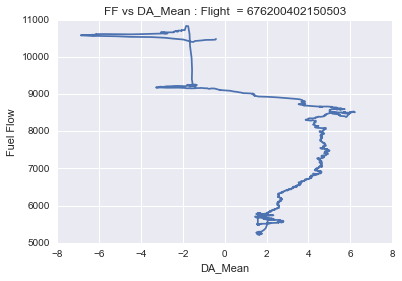

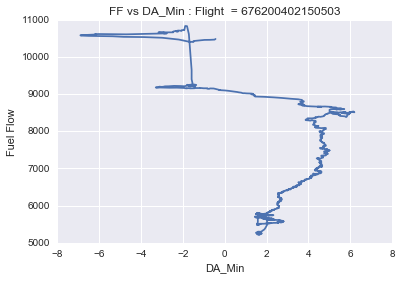

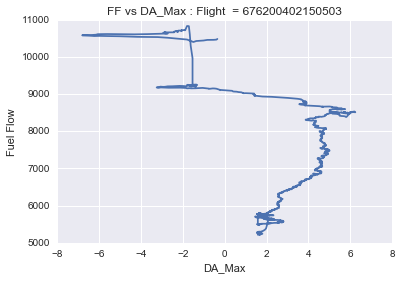

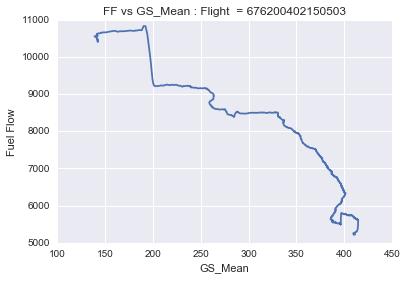

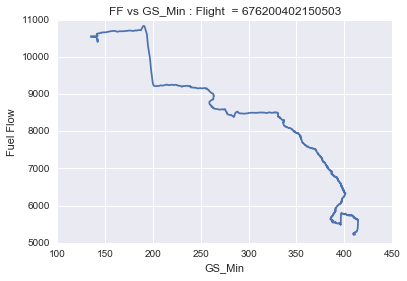

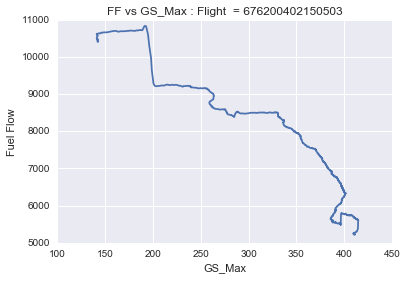

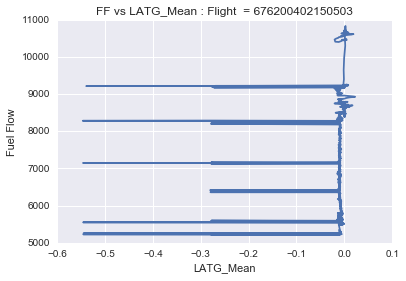

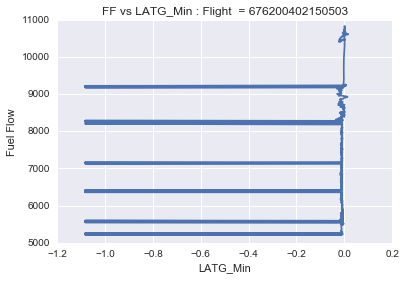

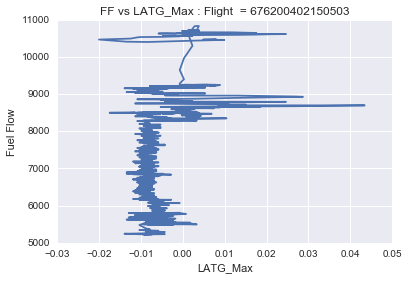

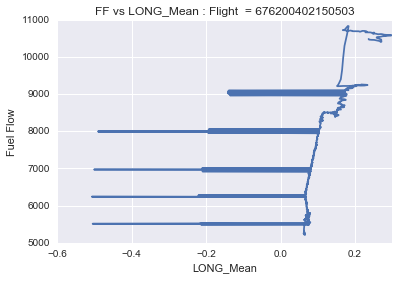

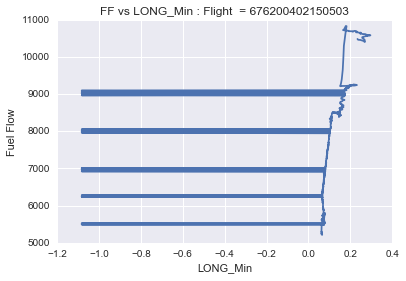

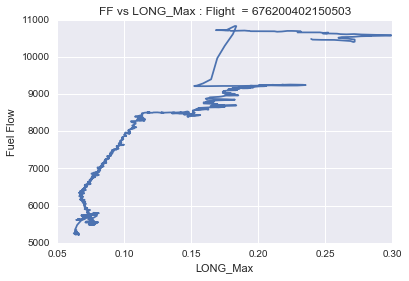

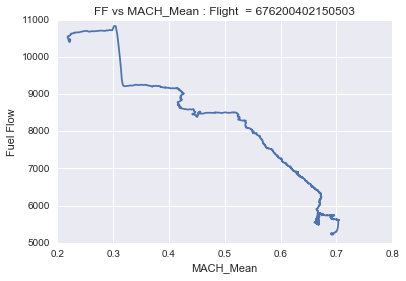

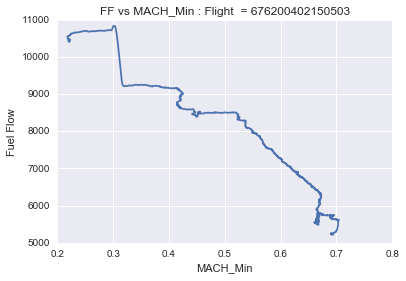

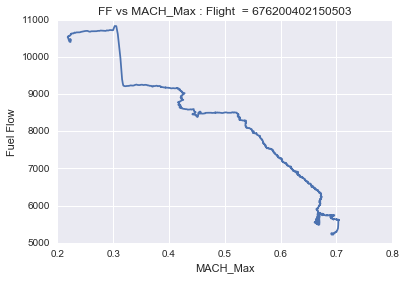

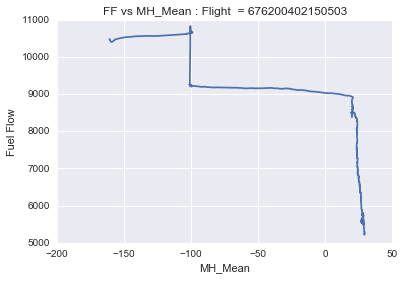

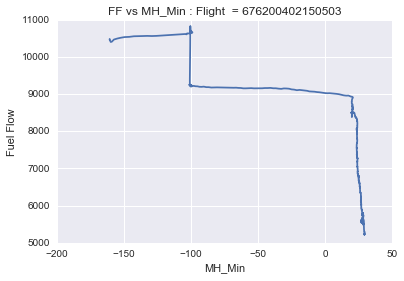

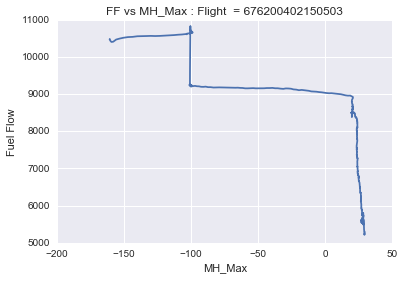

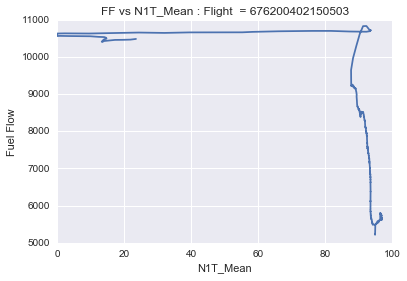

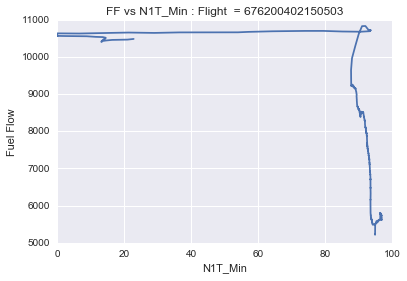

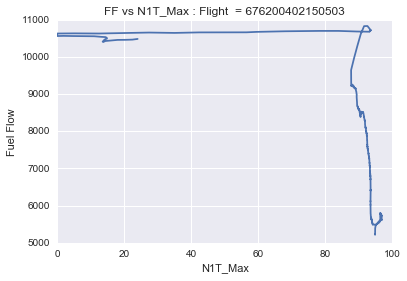

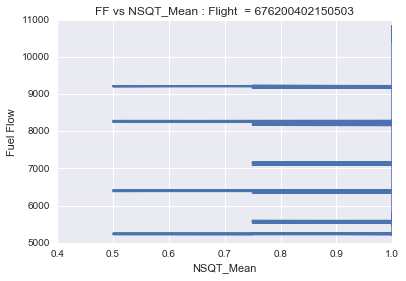

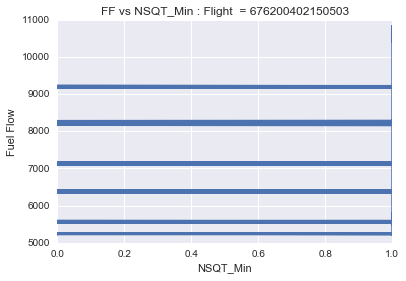

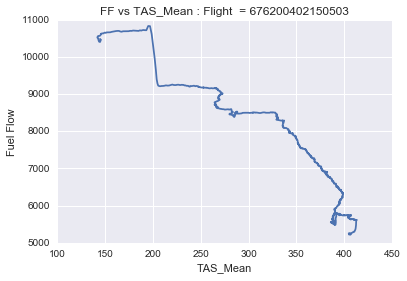

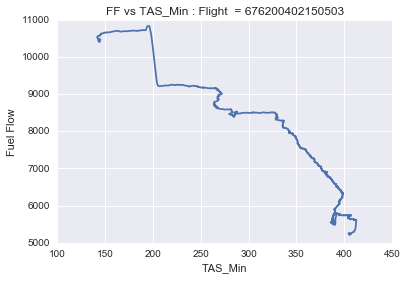

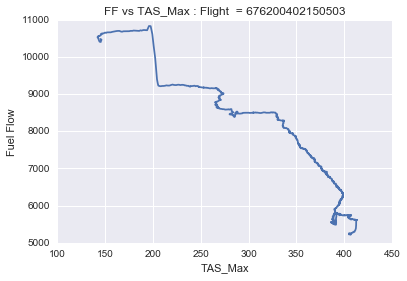

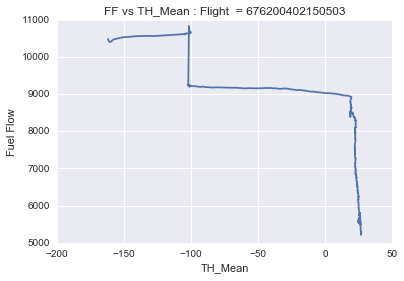

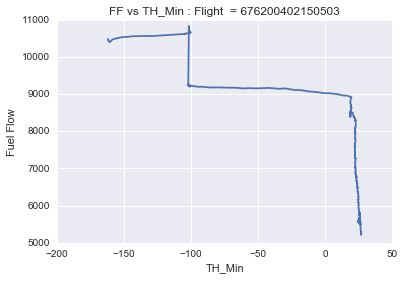

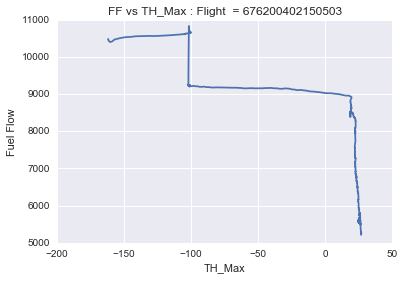

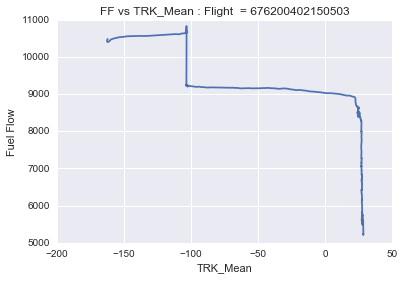

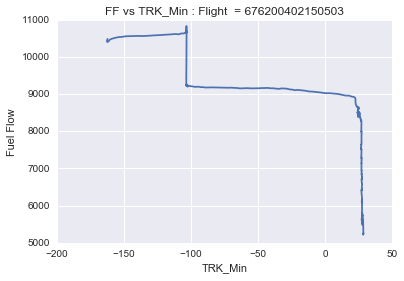

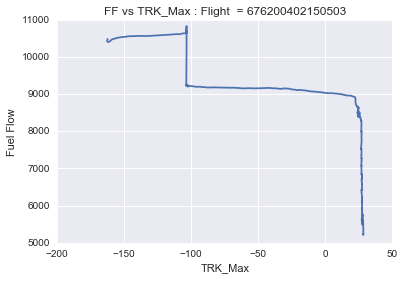

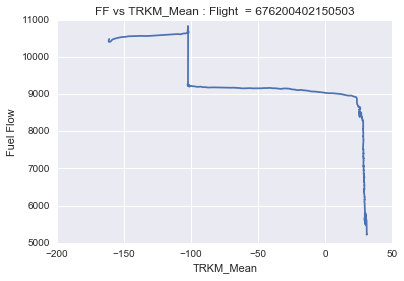

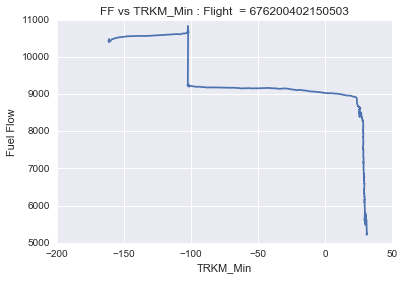

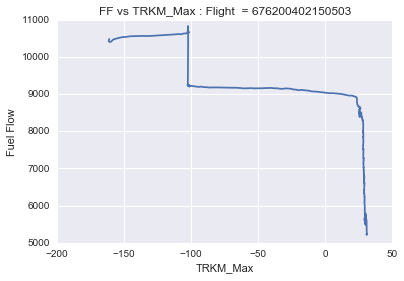

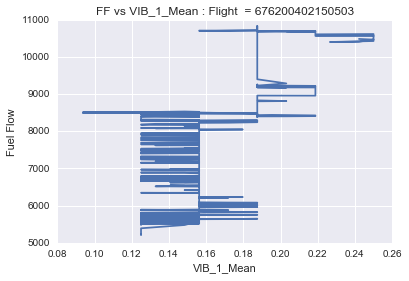

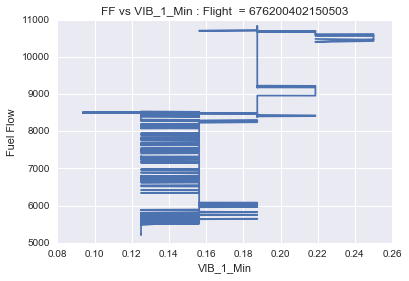

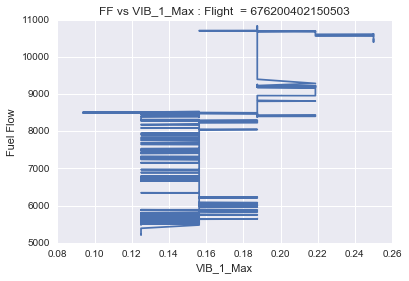

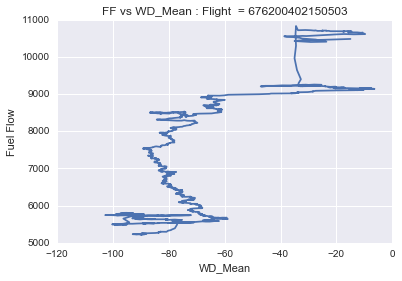

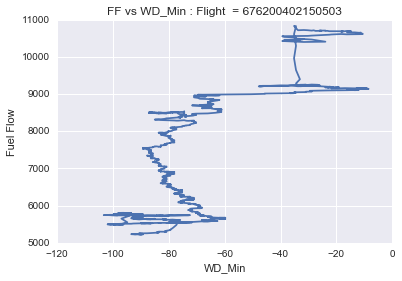

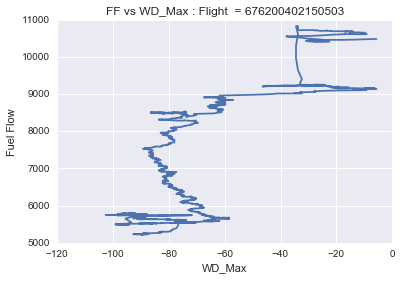

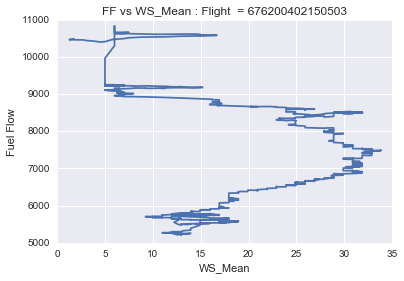

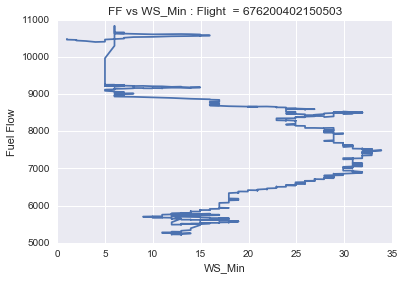

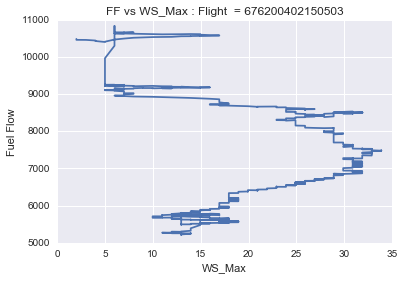

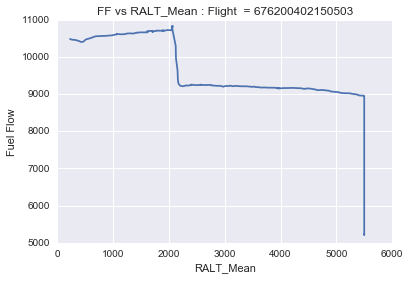

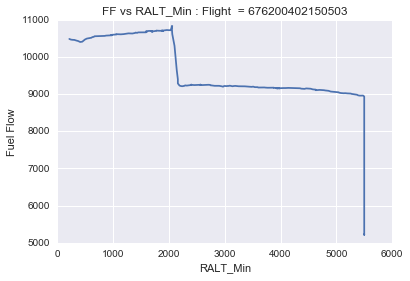

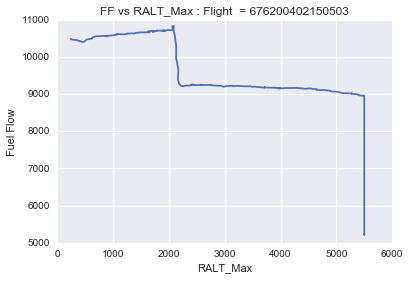

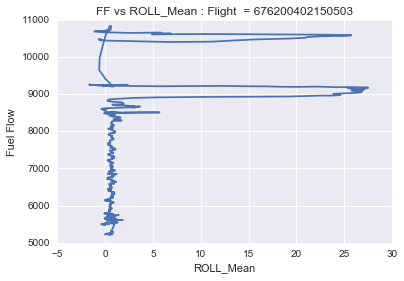

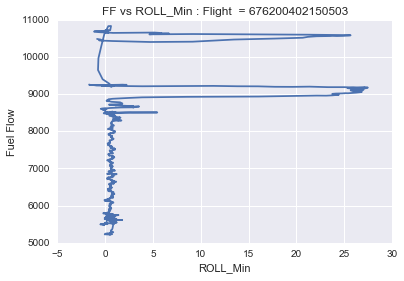

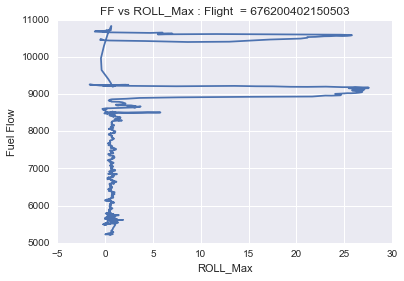

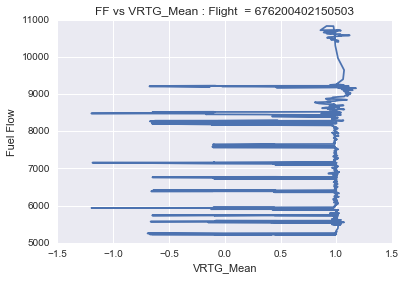

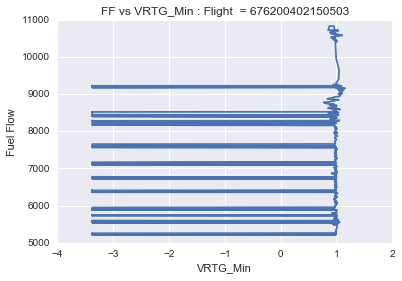

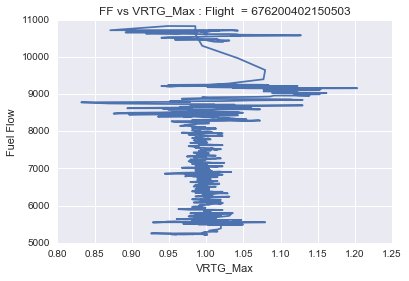

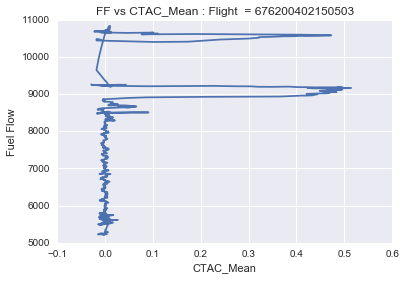

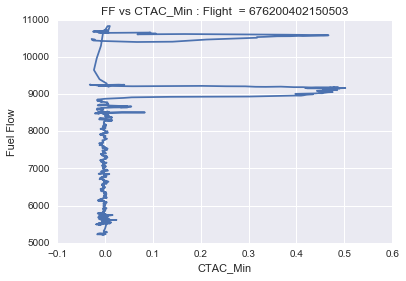

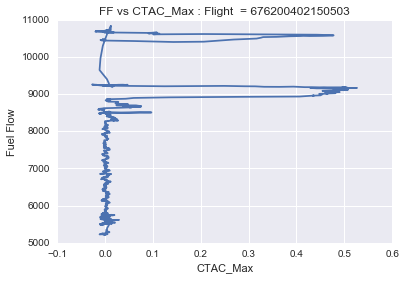

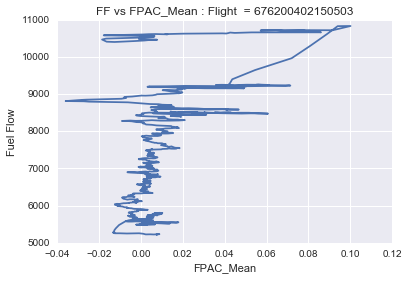

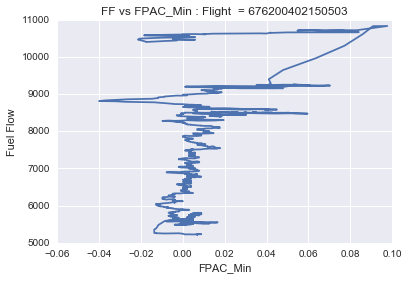

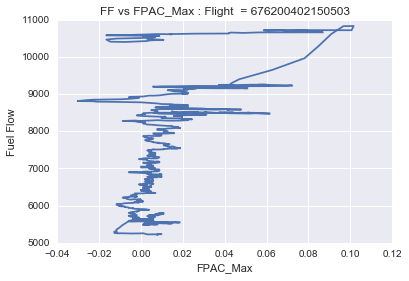

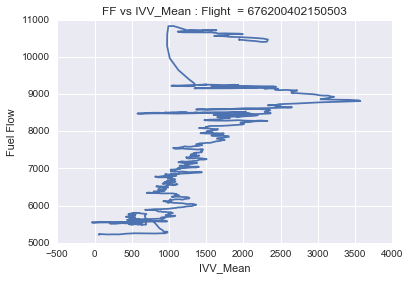

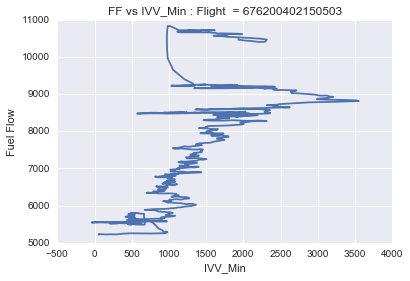

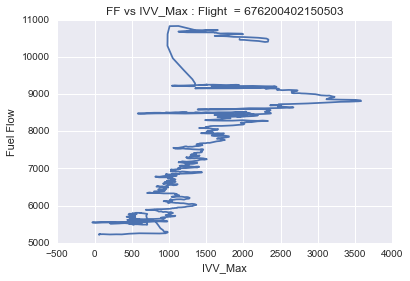

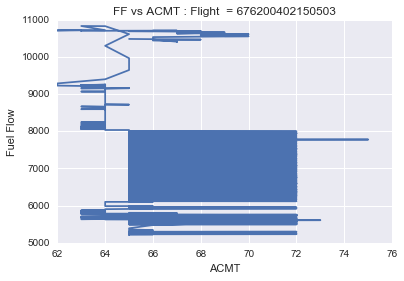

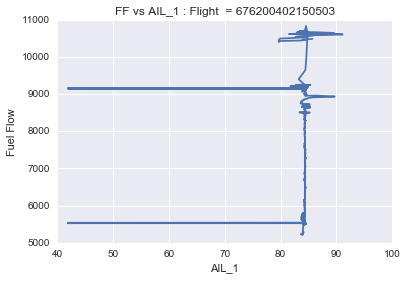

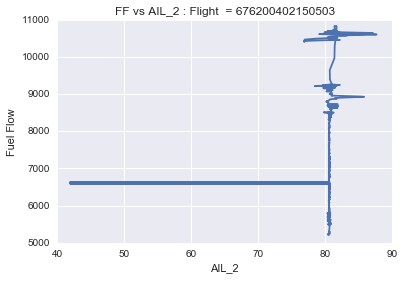

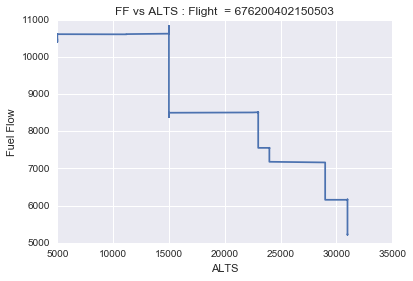

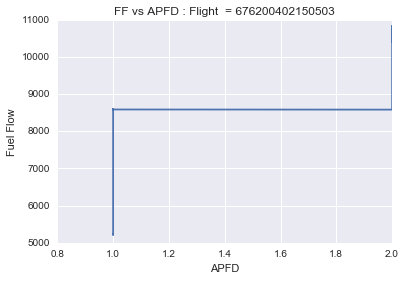

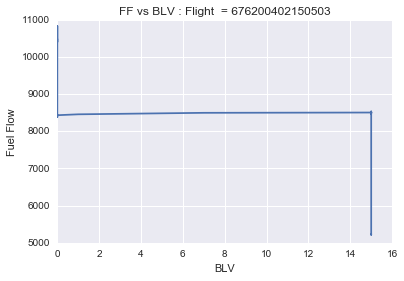

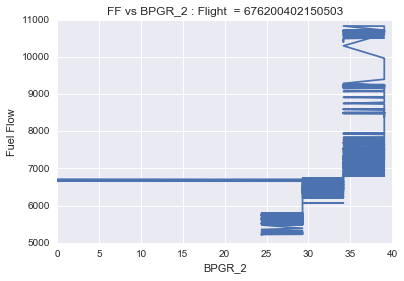

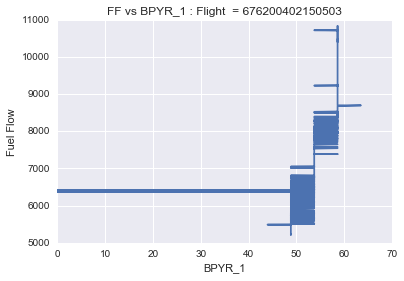

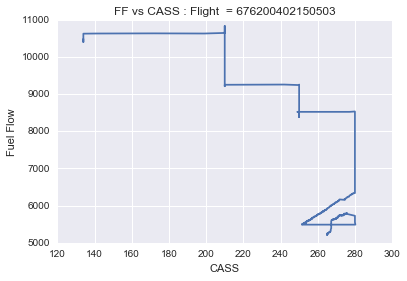

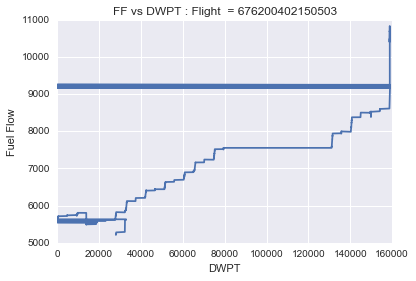

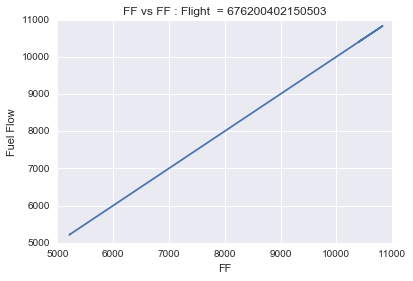

In [32]:
pdf = matplotlib.backends.backend_pdf.PdfPages("E:\data\output3_ff_vs_feature_phase4.pdf")
for feature in flight_features:
    if feature not in list_of_vars_close_to_zero:
        fig3 = plt.figure()
        plt.plot(data_p3_sample[feature][data_p3_sample['Flight_instance_ID']=='676200402150503'],data_p3_sample['FF'][data_p3_sample['Flight_instance_ID']=='676200402150503'] )
        plt.xlabel(feature)
        plt.ylabel("Fuel Flow")
        plt.title("FF vs "+feature+" : Flight  = 676200402150503")    
        
        pdf.savefig(fig3)
pdf.close()

In [34]:
def count_null(item):
    if item is None:
        return 1
    else:
        return 0

def check_nulls(data_set):
    none_counter = 0
    for i in range(len(data_set.columns.values)):
        if sum(data_p3_sample.iloc[:,i].map(count_null)) > 0:
            print data_set.columns.values[i], sum(data_set.iloc[:,i].map(count_null))
            none_counter += 1
    if none_counter == 0:
        print "No nulls"
        
check_nulls(data_p3_sample)

No nulls


In [67]:
# Correlation matrixx
new_feature_list = []
for i in flight_features:
    if i not in list_of_vars_close_to_zero:
        new_feature_list.append(i)
len(new_feature_list)
data_p4_sample=copy.deepcopy(data_p3_sample[new_feature_list])
data_p4_sample=data_p4_sample[data_p4_sample.columns[~data_p4_sample.columns.str.contains('_Min')]]
data_p4_sample=data_p4_sample[data_p4_sample.columns[~data_p4_sample.columns.str.contains('_Max')]]

data_p4_sample.shape

(251700, 83)

In [23]:
data_p4_sample.columns.values

array(['ELEV_1', 'ELEV_2', 'FADF', 'FIRE_2', 'FIRE_4', 'FLAP', 'FQTY_1',
       'FQTY_2', 'FQTY_4', 'GLS', 'HDGS', 'HF2', 'HYDY', 'LATP', 'LMOD',
       'LOC', 'LONP', 'MNS', 'MRK', 'N1CO', 'OIT_1', 'OIT_2', 'OIT_3',
       'OIT_4', 'PACK', 'POVT', 'PTRM', 'SAT', 'SMOK', 'SPLG', 'SPL_1',
       'SPL_2', 'TAT', 'TMAG', 'TMODE', 'VHF1', 'VHF3', 'VMODE', 'VSPS',
       'APUF_Mean', 'CCPC_Mean', 'CCPF_Mean', 'CWPC_Mean', 'CWPF_Mean',
       'PI_Mean', 'PS_Mean', 'PSA_Mean', 'PT_Mean', 'RUDD_Mean',
       'RUDP_Mean', 'SHKR_Mean', 'ALT_Mean', 'ALTR_Mean', 'AOA1_Mean',
       'AOA2_Mean', 'AOAC_Mean', 'AOAI_Mean', 'BAL1_Mean', 'BAL2_Mean',
       'CAS_Mean', 'CASM_Mean', 'DA_Mean', 'GS_Mean', 'LATG_Mean',
       'LONG_Mean', 'MACH_Mean', 'MH_Mean', 'N1T_Mean', 'NSQT_Mean',
       'TAS_Mean', 'TH_Mean', 'TRK_Mean', 'TRKM_Mean', 'VIB_1_Mean',
       'WD_Mean', 'WS_Mean', 'RALT_Mean', 'ROLL_Mean', 'VRTG_Mean',
       'CTAC_Mean', 'FPAC_Mean', 'IVV_Mean', 'ACMT', 'AIL_1', 'AIL_2',
       'ALTS',

In [24]:
for i in data_p4_sample.columns.values:
    data_p4_sample[i].astype(float)

data_p4_sample.columns.values

array(['ELEV_1', 'ELEV_2', 'FADF', 'FIRE_2', 'FIRE_4', 'FLAP', 'FQTY_1',
       'FQTY_2', 'FQTY_4', 'GLS', 'HDGS', 'HF2', 'HYDY', 'LATP', 'LMOD',
       'LOC', 'LONP', 'MNS', 'MRK', 'N1CO', 'OIT_1', 'OIT_2', 'OIT_3',
       'OIT_4', 'PACK', 'POVT', 'PTRM', 'SAT', 'SMOK', 'SPLG', 'SPL_1',
       'SPL_2', 'TAT', 'TMAG', 'TMODE', 'VHF1', 'VHF3', 'VMODE', 'VSPS',
       'APUF_Mean', 'CCPC_Mean', 'CCPF_Mean', 'CWPC_Mean', 'CWPF_Mean',
       'PI_Mean', 'PS_Mean', 'PSA_Mean', 'PT_Mean', 'RUDD_Mean',
       'RUDP_Mean', 'SHKR_Mean', 'ALT_Mean', 'ALTR_Mean', 'AOA1_Mean',
       'AOA2_Mean', 'AOAC_Mean', 'AOAI_Mean', 'BAL1_Mean', 'BAL2_Mean',
       'CAS_Mean', 'CASM_Mean', 'DA_Mean', 'GS_Mean', 'LATG_Mean',
       'LONG_Mean', 'MACH_Mean', 'MH_Mean', 'N1T_Mean', 'NSQT_Mean',
       'TAS_Mean', 'TH_Mean', 'TRK_Mean', 'TRKM_Mean', 'VIB_1_Mean',
       'WD_Mean', 'WS_Mean', 'RALT_Mean', 'ROLL_Mean', 'VRTG_Mean',
       'CTAC_Mean', 'FPAC_Mean', 'IVV_Mean', 'ACMT', 'AIL_1', 'AIL_2',
       'ALTS',

In [57]:
data_p4_sample = data_p4_sample.astype(float)
data_p4_sample.dtypes
data_p4_sample.corr()

ELEV_1    ELEV_2      FLAP    FQTY_1    FQTY_2    FQTY_4  \
ELEV_1      1.000000 -0.000075 -0.040647 -0.009565  0.009605 -0.011517   
ELEV_2     -0.000075  1.000000  0.145165  0.055213  0.075439  0.055449   
FLAP       -0.040647  0.145165  1.000000  0.074721  0.093383  0.075878   
FQTY_1     -0.009565  0.055213  0.074721  1.000000  0.473590  0.994683   
FQTY_2      0.009605  0.075439  0.093383  0.473590  1.000000  0.476748   
FQTY_4     -0.011517  0.055449  0.075878  0.994683  0.476748  1.000000   
GLS         0.027773  0.072447  0.153304  0.040705  0.040868  0.045133   
HDGS        0.042520 -0.060081 -0.096400 -0.063503 -0.010176 -0.057416   
LATP        0.005163 -0.041632  0.004541  0.016056  0.213619  0.030057   
LMOD       -0.015514 -0.109107 -0.219425 -0.097916 -0.064519 -0.098765   
LOC        -0.031527 -0.008245 -0.009521 -0.006919  0.034411 -0.002792   
LONP       -0.087116  0.000194 -0.015265  0.162286  0.012445  0.163171   
MNS        -0.050146 -0.405282 -0.616280 -0.109739 -0.181989 -0.114652   
MRK        -0.001353  0.002402  0.003961  0.001025  0.001668  0.001317   
N1CO       -0.033554  0.132420  0.951210  0.077425  0.089652  0.078269   
OIT_1      -0.035778 -0.131955 -0.185344 -0.062671 -0.060541 -0.063980   
OIT_2      -0.041767 -0.140708 -0.219036 -0.061739 -0.069189 -0.063780   
OIT_3      -0.039686 -0.142028 -0.206642 -0.067431 -0.067193 -0.069238   
OIT_4      -0.032593 -0.105123 -0.179230 -0.050934 -0.043552 -0.051495   
PACK       -0.011094 -0.127841 -0.761107 -0.088961 -0.109116 -0.088595   
PTRM       -0.060057 -0.069928  0.041569 -0.104348 -0.104383 -0.105377   
SAT         0.004267  0.458833  0.445300  0.095142  0.184451  0.099592   
SPL_1       0.025965  0.182334  0.078090 -0.006830  0.054418 -0.003503   
SPL_2       0.030895  0.075665  0.156856  0.105431  0.074117  0.099519   
TAT        -0.021286  0.457498  0.345954  0.080161  0.173376  0.084274   
TMODE       0.022293 -0.132613 -0.798193 -0.085084 -0.075577 -0.087796   
VHF1        0.005721 -0.038759 -0.091214 -0.013407 -0.009419 -0.013028   
VHF3       -0.001363  0.000054  0.001833 -0.001018  0.003806 -0.000822   
VMODE       0.045630  0.138654  0.573237  0.042528  0.083632  0.044019   
VSPS       -0.047645 -0.103189 -0.098752  0.000957 -0.061558 -0.012720   
...              ...       ...       ...       ...       ...       ...   
LATG_Mean  -0.000918 -0.004208  0.016636  0.012213  0.013569  0.011802   
LONG_Mean   0.050085  0.186300  0.309551  0.070367  0.089018  0.072725   
MACH_Mean  -0.049063 -0.389192 -0.658776 -0.114631 -0.180153 -0.118987   
MH_Mean     0.041379 -0.058957 -0.080509 -0.058746 -0.004432 -0.053004   
N1T_Mean   -0.004482 -0.120303 -0.684370 -0.057021 -0.073762 -0.058512   
NSQT_Mean  -0.003560 -0.004319  0.004959 -0.000171 -0.000207 -0.000324   
TAS_Mean   -0.057415 -0.358993 -0.697217 -0.116100 -0.173794 -0.120275   
TH_Mean     0.041152 -0.041195 -0.040722 -0.046007  0.010330 -0.039837   
TRK_Mean    0.041403 -0.038334 -0.032270 -0.049602  0.010993 -0.042589   
TRKM_Mean   0.041380 -0.052372 -0.056724 -0.055073  0.002056 -0.048496   
VIB_1_Mean  0.024676  0.055176  0.274531  0.189678  0.130309  0.187905   
WD_Mean     0.047624 -0.001299  0.068497 -0.058600 -0.002889 -0.055351   
WS_Mean     0.002678 -0.233762 -0.214191 -0.025781 -0.071813 -0.029524   
RALT_Mean  -0.012517 -0.178846 -0.862334 -0.100207 -0.122852 -0.101739   
ROLL_Mean   0.004135 -0.000061 -0.028497 -0.017045 -0.010827 -0.014786   
VRTG_Mean   0.000525 -0.009043 -0.008849  0.002061  0.000883  0.001930   
CTAC_Mean   0.002545 -0.004614 -0.028259 -0.011329 -0.005081 -0.009374   
FPAC_Mean   0.028101  0.216462  0.354680  0.050328  0.083109  0.053754   
IVV_Mean    0.072262  0.334227  0.127297 -0.002420  0.067276  0.001398   
ACMT       -0.034418 -0.165429 -0.062979 -0.034668 -0.060857 -0.037185   
AIL_1       0.008694 -0.040522  0.000518 -0.099818 -0.083634 -0.104938   
AIL_2      -0.004916  0.001445  0.055582  0.002487  0.001507  0.003127   
ALTS       -0.0325

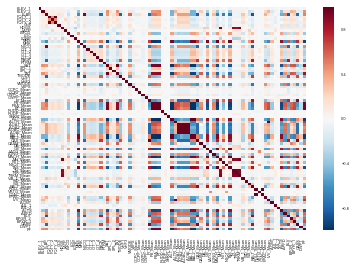

In [45]:
pdf = matplotlib.backends.backend_pdf.PdfPages("E:\data\correlation_matrix_phase4.pdf")
matplotlib.style.use('ggplot')
import seaborn as sns
corr = data_p4_sample.corr()
fig4=plt.figure()
sns.set(font_scale=0.4)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,label='small')
pdf.savefig(fig4)
pdf.close()

In [84]:
from scipy import stats
def optimum_lag(var):
    maximum=0
    minimum=0
    index_min =0
    index_max =0
    for i in range(1,100):
        var_new=data_p4_sample[var].shift(i)
        if abs(stats.spearmanr(data_p4_sample['FF'], var_new)[0]) > abs(stats.spearmanr(data_p4_sample['FF'], data_p4_sample[var])[0]):
            corr =  stats.spearmanr(data_p4_sample['FF'], var_new)[0]
            if abs(corr)<abs(minimum):
                minimum = corr
                index_min =i
            elif abs(corr)>abs(maximum):
                maximum = corr
                index_max=i
    #return index_min, index_max,minimum, maximum#,  data_p4_sample[var].shift(index_max)
            return maximum, index_max, (abs(stats.spearmanr(data_p4_sample['FF'], var_new)[0]) - abs(stats.spearmanr(data_p4_sample['FF'], data_p4_sample[var])[0]))
            


In [68]:
data_p4_sample.columns

Index([u'ELEV_1', u'ELEV_2', u'FLAP', u'FQTY_1', u'FQTY_2', u'FQTY_4', u'GLS',
       u'HDGS', u'LATP', u'LMOD', u'LOC', u'LONP', u'MNS', u'MRK', u'N1CO',
       u'OIT_1', u'OIT_2', u'OIT_3', u'OIT_4', u'PACK', u'PTRM', u'SAT',
       u'SPL_1', u'SPL_2', u'TAT', u'TMODE', u'VHF1', u'VHF3', u'VMODE',
       u'VSPS', u'CCPC_Mean', u'CCPF_Mean', u'CWPC_Mean', u'CWPF_Mean',
       u'PI_Mean', u'PS_Mean', u'PSA_Mean', u'PT_Mean', u'RUDD_Mean',
       u'RUDP_Mean', u'SHKR_Mean', u'ALT_Mean', u'ALTR_Mean', u'AOA1_Mean',
       u'AOA2_Mean', u'AOAC_Mean', u'AOAI_Mean', u'BAL1_Mean', u'BAL2_Mean',
       u'CAS_Mean', u'CASM_Mean', u'DA_Mean', u'GS_Mean', u'LATG_Mean',
       u'LONG_Mean', u'MACH_Mean', u'MH_Mean', u'N1T_Mean', u'NSQT_Mean',
       u'TAS_Mean', u'TH_Mean', u'TRK_Mean', u'TRKM_Mean', u'VIB_1_Mean',
       u'WD_Mean', u'WS_Mean', u'RALT_Mean', u'ROLL_Mean', u'VRTG_Mean',
       u'CTAC_Mean', u'FPAC_Mean', u'IVV_Mean', u'ACMT', u'AIL_1', u'AIL_2',
       u'ALTS', u'APFD', u'BLV', u

In [85]:
for i in data_p4_sample.columns:
    if i !='FF':
        print i +  str(optimum_lag(i))

ELEV_1(0.087716764522871624, 1, 0.00044737753421898729)
ELEV_2None
FLAP(0.21240052927782957, 4, 0.0017420315028663091)
FQTY_1None
FQTY_2None
FQTY_4None
GLS(0.16943894260314385, 2, 0.00051765403392206588)
HDGSNone
LATPNone
LMODNone
LOC(0.0074015838386496469, 1, 0.00027004097000270406)
LONP(-0.0093718736107186607, 1, 4.0234810013270103e-05)
MNSNone
MRK(-0.013448724833091735, 2, 0.011777885001291793)
N1CONone
OIT_1None
OIT_2None
OIT_3None
OIT_4None
PACKNone
PTRMNone
SATNone
SPL_1None
SPL_2None
TATNone
TMODENone
VHF1None
VHF3(-0.013446638795723317, 2, 0.009994787633497159)
VMODENone
VSPSNone
CCPC_MeanNone
CCPF_MeanNone
CWPC_Mean(0.083265926347880964, 1, 0.00031980795190217348)
CWPF_Mean(-0.0028994808298762765, 1, 0.00020595078069537108)
PI_Mean(-0.23651910096162607, 1, 0.00081226018888858054)
PS_MeanNone
PSA_MeanNone
PT_MeanNone
RUDD_MeanNone
RUDP_Mean(-0.013246907708495563, 1, 5.8138665865483524e-05)
SHKR_Mean(-0.014394677410704056, 2, 0.014109171526396284)
ALT_MeanNone
ALTR_MeanNone
AOA1

In [86]:
## creating lagged variables##
lag_amount=30
print data_p4_sample.columns.values

['ELEV_1' 'ELEV_2' 'FLAP' 'FQTY_1' 'FQTY_2' 'FQTY_4' 'GLS' 'HDGS' 'LATP'
 'LMOD' 'LOC' 'LONP' 'MNS' 'MRK' 'N1CO' 'OIT_1' 'OIT_2' 'OIT_3' 'OIT_4'
 'PACK' 'PTRM' 'SAT' 'SPL_1' 'SPL_2' 'TAT' 'TMODE' 'VHF1' 'VHF3' 'VMODE'
 'VSPS' 'CCPC_Mean' 'CCPF_Mean' 'CWPC_Mean' 'CWPF_Mean' 'PI_Mean' 'PS_Mean'
 'PSA_Mean' 'PT_Mean' 'RUDD_Mean' 'RUDP_Mean' 'SHKR_Mean' 'ALT_Mean'
 'ALTR_Mean' 'AOA1_Mean' 'AOA2_Mean' 'AOAC_Mean' 'AOAI_Mean' 'BAL1_Mean'
 'BAL2_Mean' 'CAS_Mean' 'CASM_Mean' 'DA_Mean' 'GS_Mean' 'LATG_Mean'
 'LONG_Mean' 'MACH_Mean' 'MH_Mean' 'N1T_Mean' 'NSQT_Mean' 'TAS_Mean'
 'TH_Mean' 'TRK_Mean' 'TRKM_Mean' 'VIB_1_Mean' 'WD_Mean' 'WS_Mean'
 'RALT_Mean' 'ROLL_Mean' 'VRTG_Mean' 'CTAC_Mean' 'FPAC_Mean' 'IVV_Mean'
 'ACMT' 'AIL_1' 'AIL_2' 'ALTS' 'APFD' 'BLV' 'BPGR_2' 'BPYR_1' 'CASS' 'DWPT'
 'FF']


In [87]:
vars_to_lag=['ALT_Mean', 'AOA1_Mean', 'BAL1_Mean', 'BPYR_1', 'CCPC_Mean',  'CTAC_Mean', 'CWPC_Mean', 'CWPF_Mean', 'DA_Mean',
             'DWPT', 'ELEV_1', 'ELEV_2',  'FLAP', 'FPAC_Mean', 'FQTY_1', 'FQTY_4', 'GLS',  'IVV_Mean',  'LOC', 'LONG_Mean',
             'MNS', 'N1T_Mean', 'NSQT_Mean',  'PI_Mean', 'PSA_Mean', 'PTRM', 'PT_Mean', 'RALT_Mean', 'ROLL_Mean',
             'SAT', 'SPL_1', 'VIB_1_Mean', 'VRTG_Mean' ]

In [88]:
for i in vars_to_lag:
    data_p4_sample[i+"_lagged_30"] =data_p4_sample[i].shift(lag_amount)
data_p4_sample.columns.values

array(['ELEV_1', 'ELEV_2', 'FLAP', 'FQTY_1', 'FQTY_2', 'FQTY_4', 'GLS',
       'HDGS', 'LATP', 'LMOD', 'LOC', 'LONP', 'MNS', 'MRK', 'N1CO',
       'OIT_1', 'OIT_2', 'OIT_3', 'OIT_4', 'PACK', 'PTRM', 'SAT', 'SPL_1',
       'SPL_2', 'TAT', 'TMODE', 'VHF1', 'VHF3', 'VMODE', 'VSPS',
       'CCPC_Mean', 'CCPF_Mean', 'CWPC_Mean', 'CWPF_Mean', 'PI_Mean',
       'PS_Mean', 'PSA_Mean', 'PT_Mean', 'RUDD_Mean', 'RUDP_Mean',
       'SHKR_Mean', 'ALT_Mean', 'ALTR_Mean', 'AOA1_Mean', 'AOA2_Mean',
       'AOAC_Mean', 'AOAI_Mean', 'BAL1_Mean', 'BAL2_Mean', 'CAS_Mean',
       'CASM_Mean', 'DA_Mean', 'GS_Mean', 'LATG_Mean', 'LONG_Mean',
       'MACH_Mean', 'MH_Mean', 'N1T_Mean', 'NSQT_Mean', 'TAS_Mean',
       'TH_Mean', 'TRK_Mean', 'TRKM_Mean', 'VIB_1_Mean', 'WD_Mean',
       'WS_Mean', 'RALT_Mean', 'ROLL_Mean', 'VRTG_Mean', 'CTAC_Mean',
       'FPAC_Mean', 'IVV_Mean', 'ACMT', 'AIL_1', 'AIL_2', 'ALTS', 'APFD',
       'BLV', 'BPGR_2', 'BPYR_1', 'CASS', 'DWPT', 'FF',
       'ALT_Mean_lagged_30', 'AOA1_Me

In [89]:
data_p4_sample.to_csv("E:\data\processd_data_phase_4.csv")

In [ ]:
import seaborn as sns
from pandas.tools.plotting import autocorrelation_plot
sns.set(font_scale=1)
plt.figure()
autocorrelation_plot(data_p4_sample['FF'])


In [ ]:
from pandas.tools.plotting import lag_plot
plt.figure()
lag_plot(data_p4_sample['FF'])
